# Inspect Model Output Distributions 

In [1]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1
import os, math, torch, glob, pickle, gzip, random, yaml, json
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import pchip_interpolate
from dataclasses import dataclass
from typing import List, Tuple
from pathlib import Path

print("✅ Imports successful. torch version:", torch.__version__)
try:
    import xgboost as xgb
except ImportError:
    xgb = None


env: PYTORCH_ENABLE_MPS_FALLBACK=1
✅ Imports successful. torch version: 2.8.0


### Step 2: Define Data Classes and Model Architecture

In [2]:
# --- 0. DATA CLASSES ---
@dataclass
class TrainingExample:
    unpadded_example_sequence: List[str]
    actual_pace_seconds: float
    raw_pace_data: List[Tuple[str, str, int]]

@dataclass
class RunnerForTraining:
    name_gender_dedup_int: Tuple[str, str, str, int]
    training_examples: List[TrainingExample]
    split_assignment: int

# --- 1. MODEL ARCHITECTURE ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:, :x.size(1)]

class RunTimeTransformer(nn.Module):
    def __init__(self, vocab_size, num_pace_bins, config):
        super().__init__()
        m = config['model']
        self.d_model = m['d_model']
        self.embedding = nn.Embedding(vocab_size, self.d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(self.d_model, m['max_seq_length'])
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model, 
            nhead=m['nhead'], 
            dim_feedforward=m['dim_feedforward'], 
            dropout=m['dropout'], 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=m['num_layers'])
        self.transformer.enable_nested_tensor = False
        self.output_head = nn.Linear(self.d_model, num_pace_bins)
        self._init_weights()
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        nn.init.constant_(self.output_head.bias, 0)
    def forward(self, x, padding_mask):
        sz = x.size(1)
        causal_mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool().to(x.device)
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer(x, mask=causal_mask, src_key_padding_mask=padding_mask)
        valid_lens = (~padding_mask).sum(dim=1) - 1
        return self.output_head(x[torch.arange(x.size(0)), valid_lens])

print("✅ Architecture defined.")

✅ Architecture defined.


In [3]:
# --- 2. SETTINGS & CONSTANTS ---
CHECKPOINT_PATH = "/Users/yaelelmatad/Desktop/nyrr-transform/Production_Scale_v2_HighCap/best_model.pt"
CONFIG_PATH = "/Users/yaelelmatad/Desktop/nyrr-transform/Production_Scale_v2_HighCap/config_copy.yaml"
PACE_LOOKUP_PATH = "/Users/yaelelmatad/Desktop/nyrr-transform/grammar-notebooks/pace_grammar_bins_with_statistics_2025-10-02_16:07.pickle"
DATA_SPLIT_PATH = "/Users/yaelelmatad/Desktop/nyrr-transform/Runtime/pipeline/training_splits/runners_split_0[5][0-9].pkl.gz"
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

DISTANCE_MAP = {
    'distance_name_token_1_mile': 1.0, 'distance_name_token_1POINT5_miles': 1.5,
    'distance_name_token_3_miles': 3.0, 'distance_name_token_3_kilometers': 1.86411,
    'distance_name_token_5_kilometers': 3.10686, 'distance_name_token_4_miles': 4.0,
    'distance_name_token_5_miles': 5.0, 'distance_name_token_8_kilometers': 4.97097,
    'distance_name_token_10_kilometers': 6.21371, 'distance_name_token_12_kilometers': 7.45645,
    'distance_name_token_15_kilometers': 9.32057, 'distance_name_token_10_miles': 10.0,
    'distance_name_token_18_miles': 18.0, 'distance_name_token_20_kilometers': 12.4274,
    'distance_name_token_25_kilometers': 15.5343, 'distance_name_token_30_kilometers': 18.6411,
    'distance_name_token_half_marathon': 13.1094, 'distance_name_token_marathon': 26.2188
}

VOCAB = {}; pace_lookup = {}; pace_bins = []; MAX_LEN = 329; IS_SWAPPED = False; CONFIG = {}

# New XGBoost artifacts trained on the first 50 split shards with continuous distance feature mapping
XGB_MODEL_PATH = "/Users/yaelelmatad/Desktop/nyrr-transform/Runtime/train/xgb_first50_continuous/xgboost_model.json"
XGB_FEATURE_COLUMNS_PATH = "/Users/yaelelmatad/Desktop/nyrr-transform/Runtime/train/xgb_first50_continuous/xgboost_feature_columns.pickle"
print(f"Loading resources...")
try:
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    VOCAB = checkpoint.get('vocab', {})
    STATE_DICT = checkpoint.get('model_state_dict')
    with open(PACE_LOOKUP_PATH, 'rb') as f: pace_lookup = pickle.load(f)
    
    bins = []
    for token, info in pace_lookup.items():
        if not isinstance(info, dict): continue
        med = info.get('median_pace') or info.get('median', 0)
        bins.append({'token': token, 'start': float(info['start']), 'end': float(info['end']), 'median': float(med)})
    pace_bins = sorted(bins, key=lambda x: x['median'])
    
    with open(CONFIG_PATH, 'r') as f: CONFIG = yaml.safe_load(f)
    MAX_LEN = CONFIG['model']['max_seq_length']
    IS_SWAPPED = CONFIG['model'].get('architecture') == 'swapped-tokens' or 'swapped' in CHECKPOINT_PATH.lower()
    
    model = RunTimeTransformer(len(VOCAB), len(pace_bins), config=CONFIG).to(DEVICE)
    model.load_state_dict(STATE_DICT)
    model.eval()
    
    pace_values = np.array([b['median'] for b in pace_bins])
    # Ensure strictly increasing for PCHIP
    for i in range(1, len(pace_values)):
        if pace_values[i] <= pace_values[i-1]:
            pace_values[i] = pace_values[i-1] + 0.0001
    pace_widths = np.array([b['end'] - b['start'] for b in pace_bins])
    pace_ids_list = [VOCAB.get(b['token'], 0) for b in pace_bins]
    
    # Load XGBoost artifacts (tuned baseline)
    # - Booster model (trained via xgboost.train)
    # - One-hot feature column set for exact train/val alignment
    xgb_booster = None
    xgb_feature_columns = None
    if xgb and os.path.exists(XGB_MODEL_PATH):
        xgb_booster = xgb.Booster()
        xgb_booster.load_model(XGB_MODEL_PATH)
        if os.path.exists(XGB_FEATURE_COLUMNS_PATH):
            with open(XGB_FEATURE_COLUMNS_PATH, 'rb') as f:
                payload = pickle.load(f)
            xgb_feature_columns = payload.get('columns') if isinstance(payload, dict) else payload
        print("✅ XGBoost booster + feature columns loaded.")
    print(f"✅ Resources loaded. Model ready on {DEVICE}.")
except Exception as e: print(f"ERROR: {e}"); raise e

Loading resources...
✅ XGBoost booster + feature columns loaded.
✅ Resources loaded. Model ready on mps.


In [9]:
# --- 3. HELPERS ---
def extract_runner_features_full(runner, example):
    if not example.raw_pace_data or len(example.raw_pace_data) < 2: return None
    history = example.raw_pace_data[:-1]; target_race = example.raw_pace_data[-1]
    prev_paces = [h[2] for h in history]
    avg_pace = np.mean(prev_paces); last_pace = prev_paces[-1]
    std_pace = np.std(prev_paces) if len(prev_paces) > 1 else 0
    volatility = (std_pace / avg_pace) if avg_pace > 0 else 0
    ema_pace = prev_paces[0]
    for p in prev_paces[1:]: ema_pace = 0.3 * p + 0.7 * ema_pace
    final_block = example.unpadded_example_sequence[-11:]; prev_block = example.unpadded_example_sequence[-22:-11]
    try:
        age = float(final_block[0].split('_')[1]); gender = 1 if runner.name_gender_dedup_int[2] == 'M' else 0
        cond_token = final_block[2]; hum = float(final_block[3].split('_')[-1])
        temp = float(final_block[4].split('_')[-1]); feels = float(final_block[5].split('_')[-1])
        wind = float(final_block[6].split('_')[-1]); total_span = float(final_block[9].split('_')[-1])
        w_since = float(prev_block[8].split('_')[-1]) if len(example.unpadded_example_sequence) >= 22 else 0
        prev_temp = float(prev_block[4].split('_')[-1]) if len(example.unpadded_example_sequence) >= 22 else temp
        last_dist = history[-1][0]; is_same_dist = 1 if target_race[0] == last_dist else 0
        same_dist_paces = [h[2] for h in history if h[0] == target_race[0]]
        avg_same_dist_pace = np.mean(same_dist_paces) if same_dist_paces else avg_pace
        return {
            'avg_historical_pace': avg_pace, 'last_pace': last_pace, 'ema_historical_pace': ema_pace,
            'min_historical_pace': np.min(prev_paces), 'max_historical_pace': np.max(prev_paces),
            'std_historical_pace': std_pace, 'pace_volatility': volatility, 'num_prev_races': len(prev_paces),
            'pace_trend': last_pace - prev_paces[0], 'weeks_since_last': w_since,
            'total_career_span': total_span, 'age': age, 'gender': gender, 'temp_binned': temp,
            'hum_binned': hum, 'feels_like_binned': feels, 'wind_binned': wind,
            'temp_feels_diff': temp - feels, 'temp_shock': temp - prev_temp,
            'is_same_distance': is_same_dist, 'avg_same_dist_pace': avg_same_dist_pace,
            'distance': target_race[0], 'conditions': cond_token
        }
    except: return None

# --- XGBoost tuned baseline: feature alignment + prediction ---
# Expects artifacts produced by Runtime/train/Benchmark_Baselines.py:
# - xgboost_model.json (Booster)
# - xgboost_feature_columns.pickle (list of training columns, including one-hot dummies)
#
# IMPORTANT:
# The latest XGBoost baseline was trained with:
# - distance mapped to a continuous numeric feature: distance_miles
# - conditions one-hot encoded
# (no categorical distance one-hot)

def xgb_predict_from_feats(feats: dict):
    if feats is None or xgb is None or xgb_booster is None or not xgb_feature_columns:
        return None
    try:
        dist_token = feats.get('distance', '')
        dist_miles = DISTANCE_MAP.get(dist_token)
        if dist_miles is None:
            return None

        # Build a single-row frame with the same schema used in Benchmark_Baselines.py
        row = {
            'avg_historical_pace': feats.get('avg_historical_pace', 0),
            'last_pace': feats.get('last_pace', 0),
            'ema_historical_pace': feats.get('ema_historical_pace', 0),
            'min_historical_pace': feats.get('min_historical_pace', 0),
            'max_historical_pace': feats.get('max_historical_pace', 0),
            'std_historical_pace': feats.get('std_historical_pace', 0),
            'pace_volatility': feats.get('pace_volatility', 0),
            'num_prev_races': feats.get('num_prev_races', 0),
            'pace_trend': feats.get('pace_trend', 0),
            'weeks_since_last': feats.get('weeks_since_last', 0),
            'total_career_span': feats.get('total_career_span', 0),
            'age': feats.get('age', 0),
            'gender': feats.get('gender', 0),
            'temp_binned': feats.get('temp_binned', 0),
            'hum_binned': feats.get('hum_binned', 0),
            'feels_like_binned': feats.get('feels_like_binned', 0),
            'wind_binned': feats.get('wind_binned', 0),
            'temp_feels_diff': feats.get('temp_feels_diff', 0),
            'temp_shock': feats.get('temp_shock', 0),
            'is_same_distance': feats.get('is_same_distance', 0),
            'avg_same_dist_pace': feats.get('avg_same_dist_pace', 0),
            'distance_miles': float(dist_miles),
            'conditions': feats.get('conditions', ''),
        }

        df = pd.DataFrame([row])
        df = pd.get_dummies(df, columns=['conditions'], drop_first=False)
        df = df.reindex(columns=xgb_feature_columns, fill_value=0)

        dmat = xgb.DMatrix(df)
        pred = float(xgb_booster.predict(dmat)[0])
        return pred
    except Exception:
        return None


def prepare_inference_sequence(ex, max_len, is_swapped):
    full_sequence = ex.unpadded_example_sequence
    if is_swapped:
        rearranged = []
        for i in range(0, len(full_sequence), 11):
            block = full_sequence[i:i+11]
            if len(block) < 11: continue
            swapped_block = block[0:8] + [block[10]] + [block[8]] + [block[9]]
            rearranged.extend(swapped_block)
        X_tokens = rearranged[:-3]
    else:
        X_tokens = full_sequence[:-1]
    if len(X_tokens) > max_len: X_tokens = X_tokens[-max_len:]
    return X_tokens

def plot_prediction_distribution(ex, label=""):
    X_tokens = prepare_inference_sequence(ex, MAX_LEN, IS_SWAPPED)
    num_races = (len(X_tokens) + 1) // 11
    history_len = num_races - 1
    actual_pace = float(ex.actual_pace_seconds)
    input_ids = [VOCAB.get(t, VOCAB['<unk>']) for t in X_tokens]
    input_tensor = torch.tensor([input_ids + [0]*(MAX_LEN-len(input_ids))], dtype=torch.long).to(DEVICE)
    mask = (input_tensor == 0)
    
    with torch.no_grad():
        logits = model(input_tensor, padding_mask=mask)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    p_probs = np.maximum(0, probs)
    p_density = p_probs / pace_widths
    # Interpolate on top of raw density (no Gaussian blur)
    pace_fine = np.linspace(pace_values.min(), pace_values.max(), 1000)
    density_interp = pchip_interpolate(pace_values, p_density, pace_fine)
    # Ensure non-negative and normalized integral
    density_interp = np.maximum(0, density_interp)
    integral = np.trapz(density_interp, pace_fine)
    if integral > 0: density_interp /= integral
    
    # Map back to bins for weighted stats (using original bins for mass)
    p_interp_bins = np.interp(pace_values, pace_fine, density_interp)
    p_smoothed = p_interp_bins * pace_widths # Re-binning for stats
    weighted_mean = np.sum(p_smoothed * pace_values)
    cumsum = np.cumsum(p_smoothed)
    weighted_median = pace_values[min(np.searchsorted(cumsum, 0.5), len(pace_values)-1)]
    # Mode should be the peak of the density curve, not the bin with most mass
    mode_idx = np.argmax(density_interp)
    mode_pace = pace_fine[mode_idx]
    
    plt.figure(figsize=(12, 6))
    plt.step(pace_values, p_density, where='mid', color='gray', alpha=0.4, label='Raw Bin Density')
    plt.plot(pace_fine, density_interp, color='blue', linewidth=2, label='Interpolated Density')
    plt.axvline(actual_pace, color='red', linestyle='--', linewidth=2, label=f'Actual: {actual_pace:.1f}s')
    plt.axvline(weighted_mean, color='green', linestyle=':', label=f'Mean: {weighted_mean:.1f}s')
    plt.axvline(weighted_median, color='orange', linestyle=':', label=f'Median: {weighted_median:.1f}s')
    plt.axvline(mode_pace, color='purple', linestyle='-.', label=f'Mode: {mode_pace:.1f}s')
    plt.xlim(max(0, actual_pace - 200), actual_pace + 200)
    plt.title(f"Distribution {label} | History: {history_len} prev races")
    plt.legend(); plt.grid(True, alpha=0.3); plt.show()

print("✅ Helpers defined.")

✅ Helpers defined.


Found 10 files matching pattern.
Loading /Users/yaelelmatad/Desktop/nyrr-transform/Runtime/pipeline/training_splits/runners_split_050.pkl.gz...
Loading /Users/yaelelmatad/Desktop/nyrr-transform/Runtime/pipeline/training_splits/runners_split_051.pkl.gz...
Loading /Users/yaelelmatad/Desktop/nyrr-transform/Runtime/pipeline/training_splits/runners_split_052.pkl.gz...
Loading /Users/yaelelmatad/Desktop/nyrr-transform/Runtime/pipeline/training_splits/runners_split_053.pkl.gz...
Loading /Users/yaelelmatad/Desktop/nyrr-transform/Runtime/pipeline/training_splits/runners_split_054.pkl.gz...
Loading /Users/yaelelmatad/Desktop/nyrr-transform/Runtime/pipeline/training_splits/runners_split_055.pkl.gz...
Loading /Users/yaelelmatad/Desktop/nyrr-transform/Runtime/pipeline/training_splits/runners_split_056.pkl.gz...
Loading /Users/yaelelmatad/Desktop/nyrr-transform/Runtime/pipeline/training_splits/runners_split_057.pkl.gz...
Loading /Users/yaelelmatad/Desktop/nyrr-transform/Runtime/pipeline/training_spl

/var/folders/_9/3jbt8sqd1m1bb7qq9xy9glpw0000gn/T/ipykernel_93805/1337586611.py:128: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(density_interp, pace_fine)


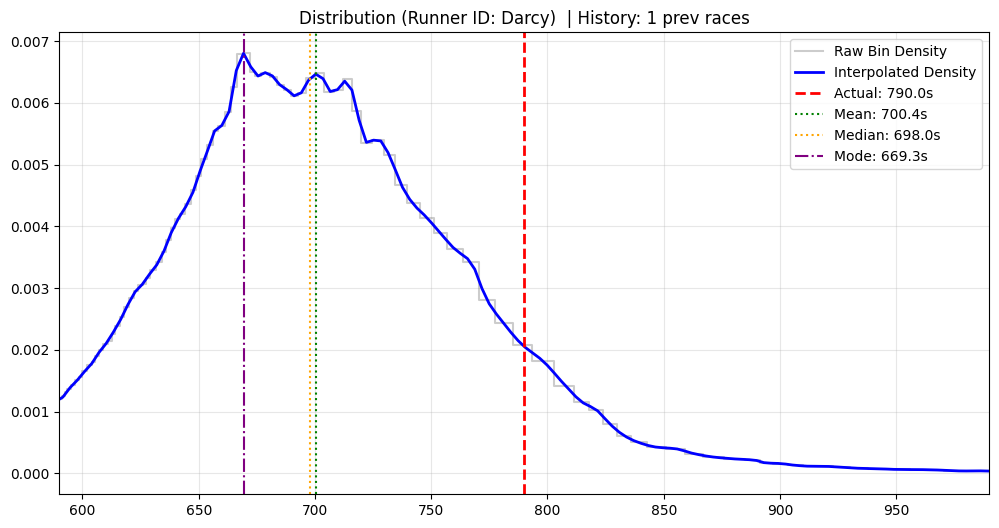

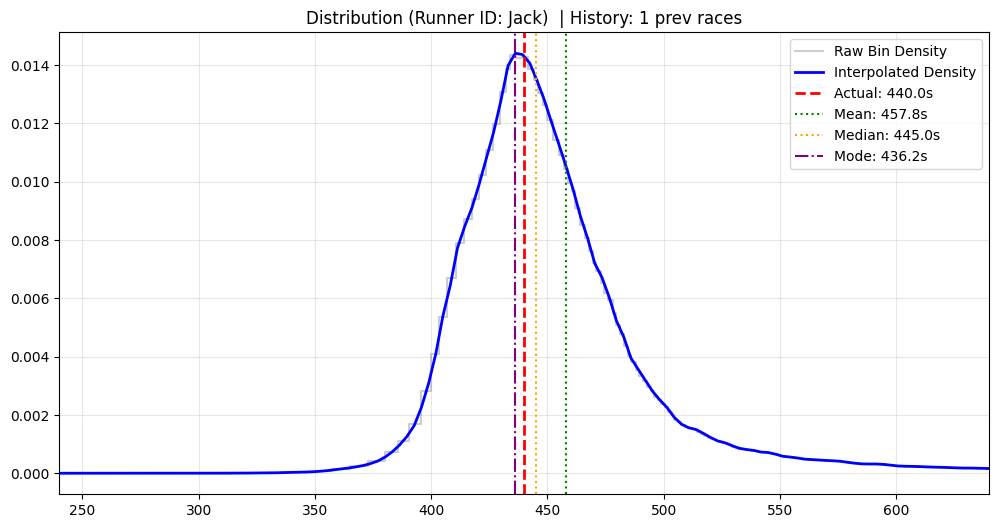

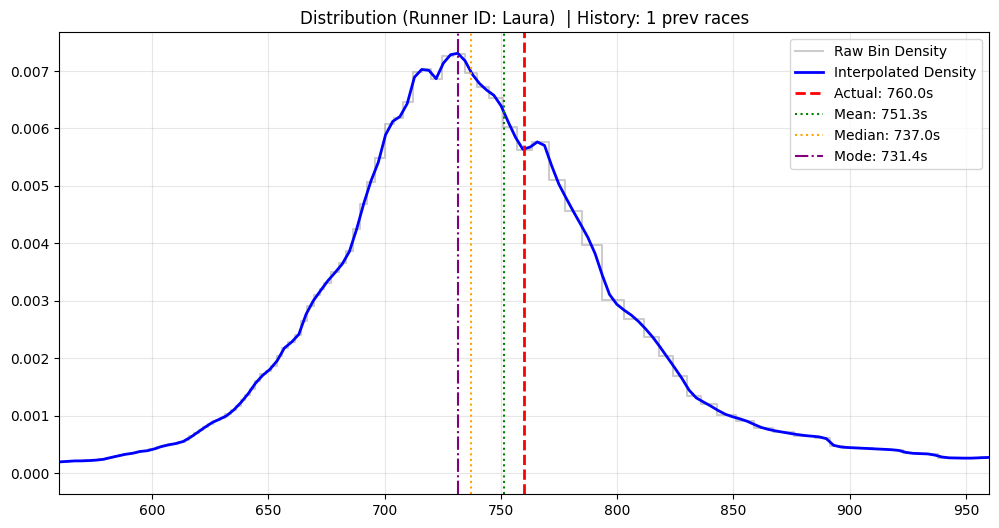

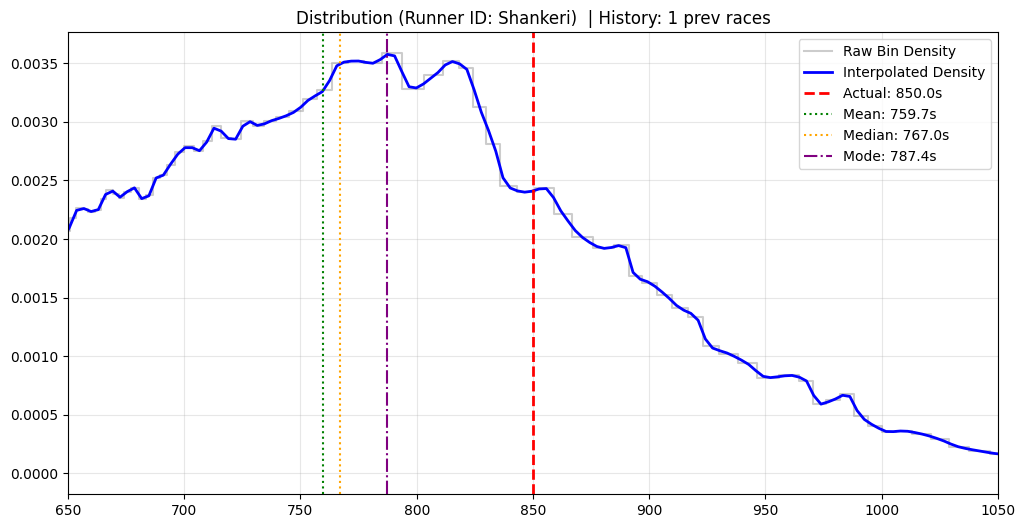

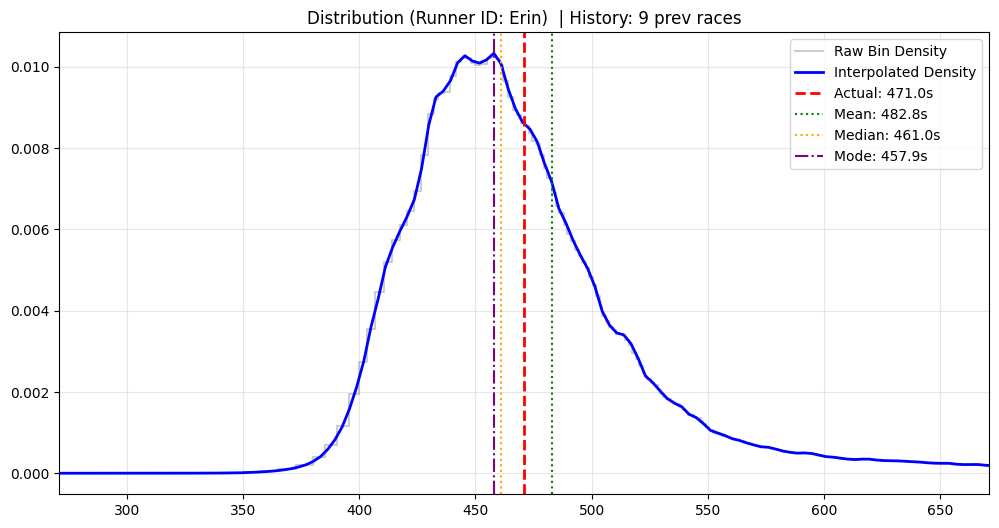

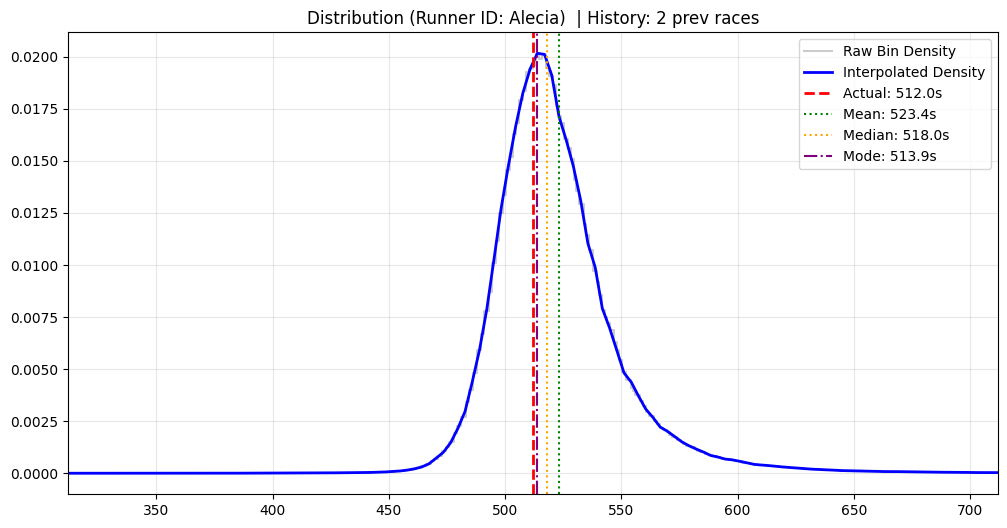

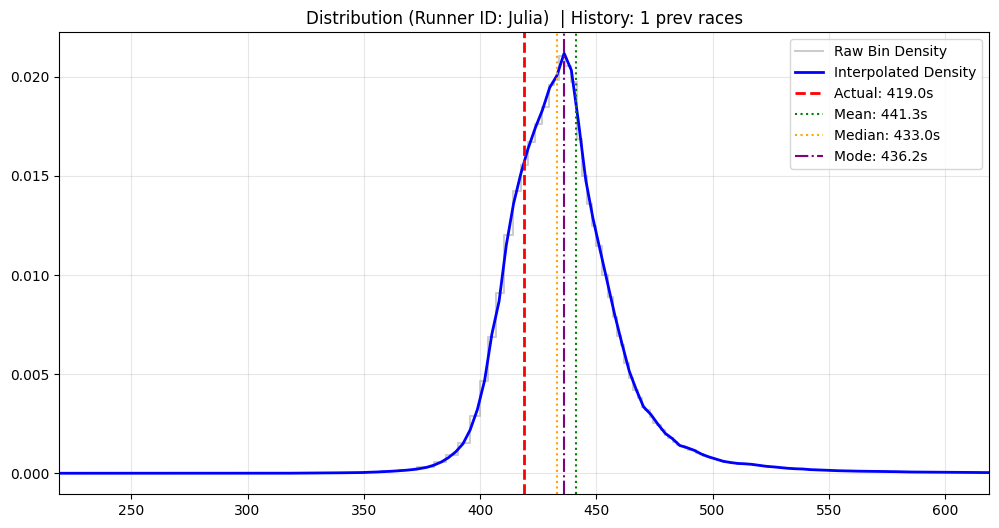

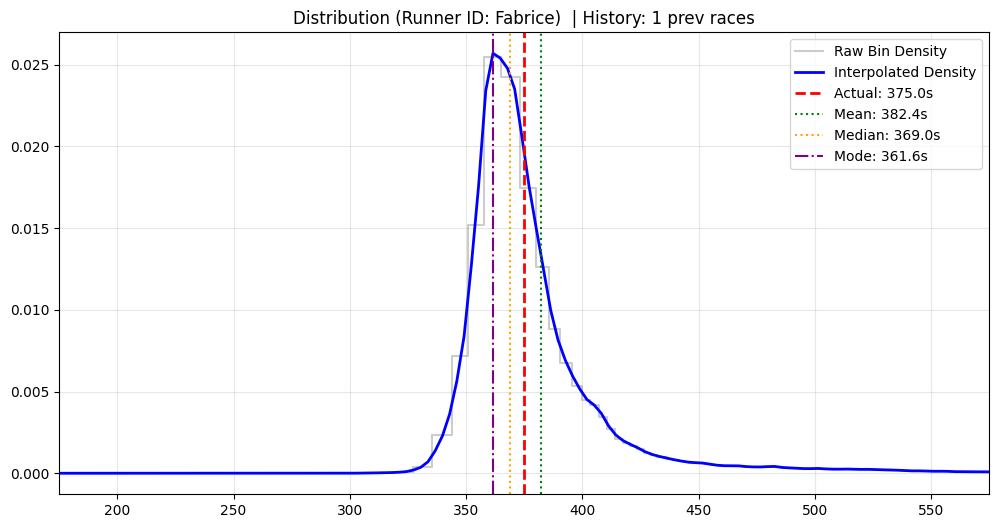

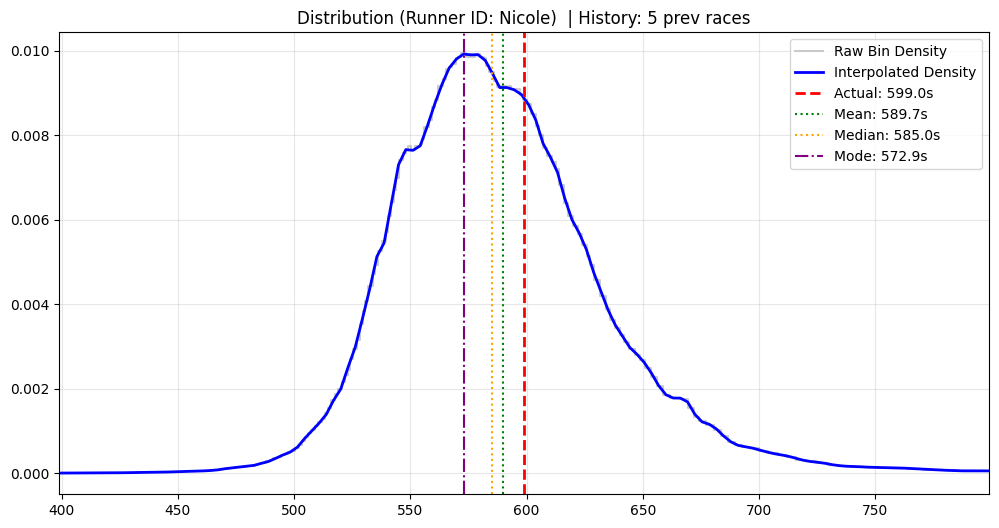

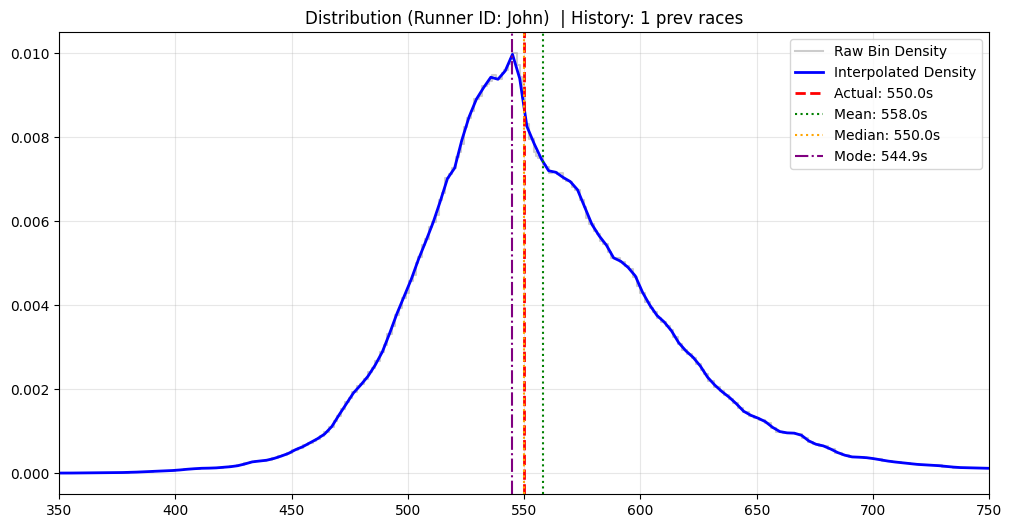

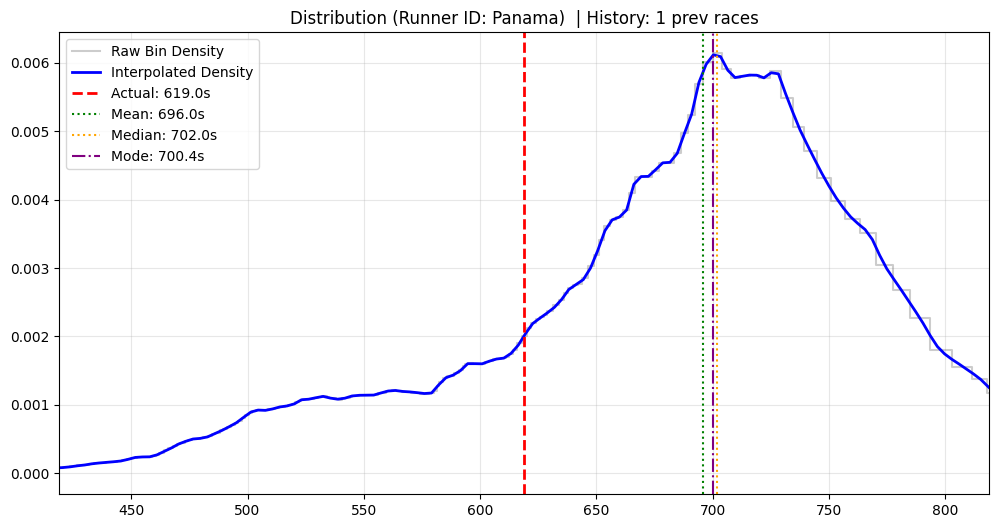

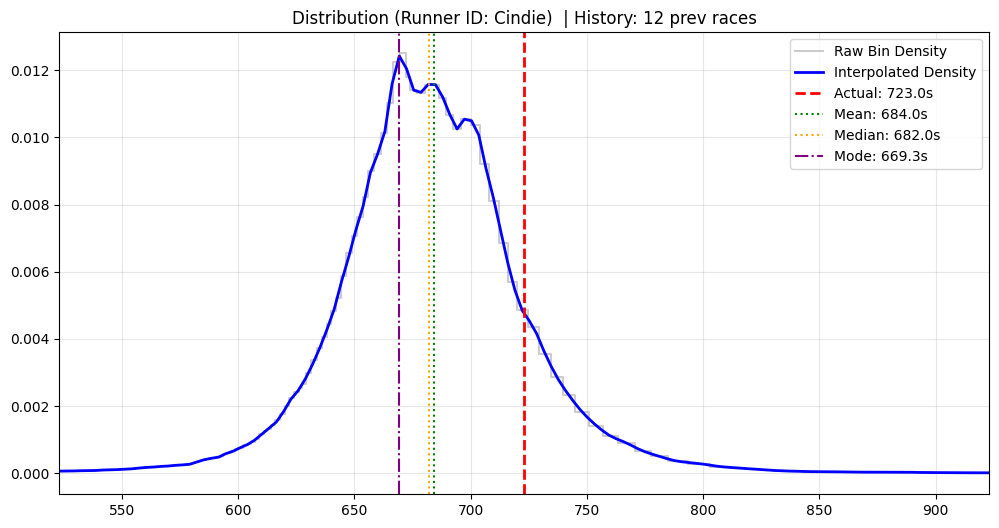

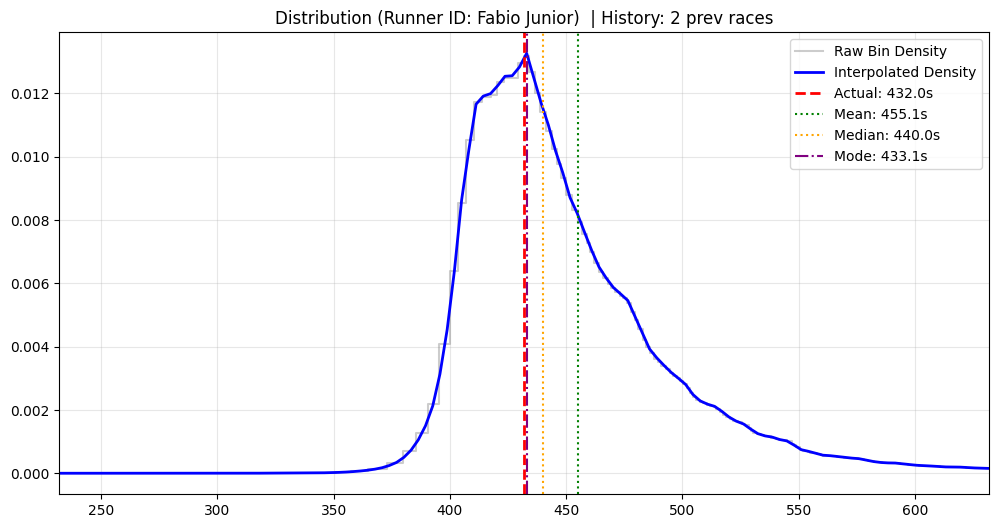

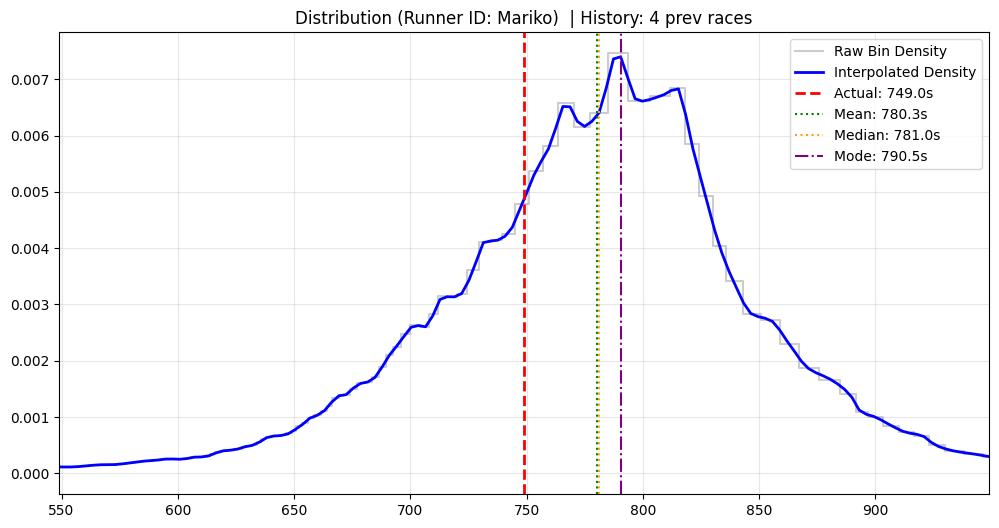

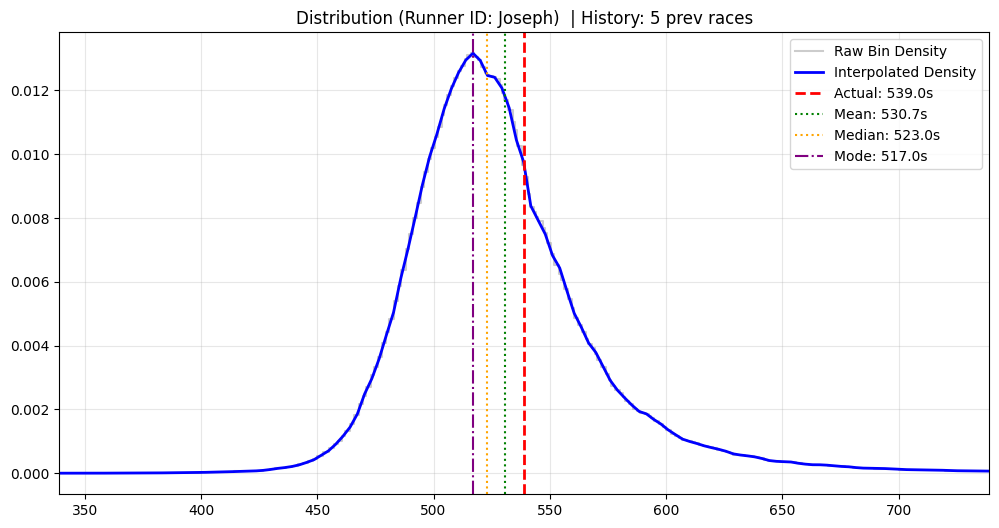

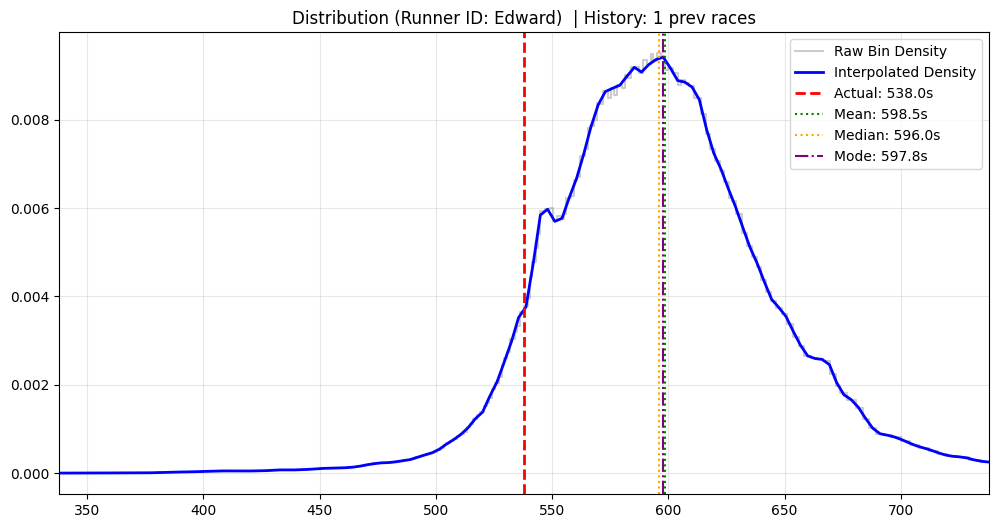

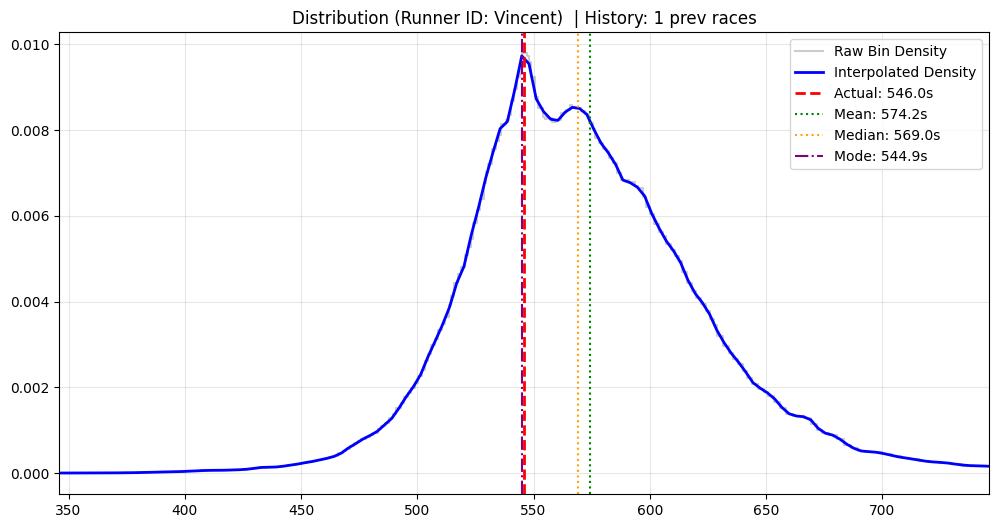

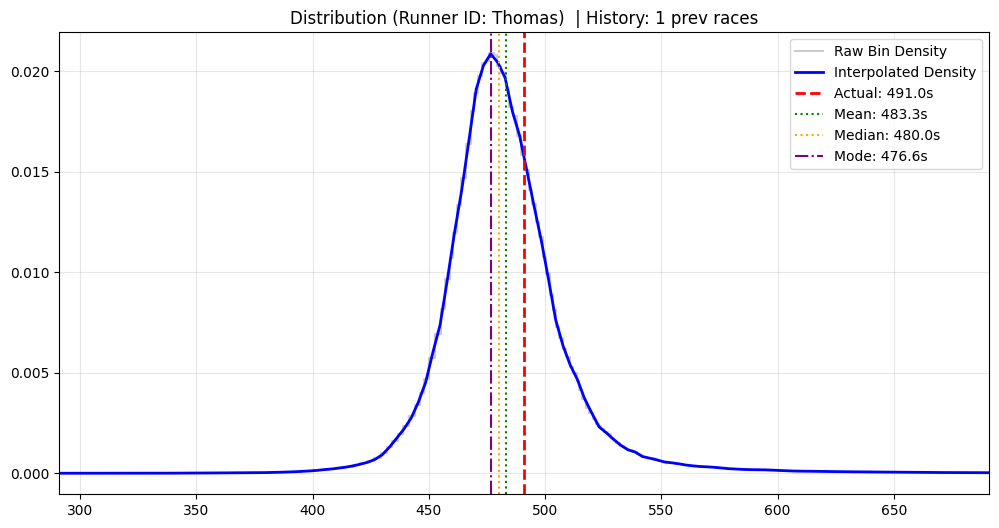

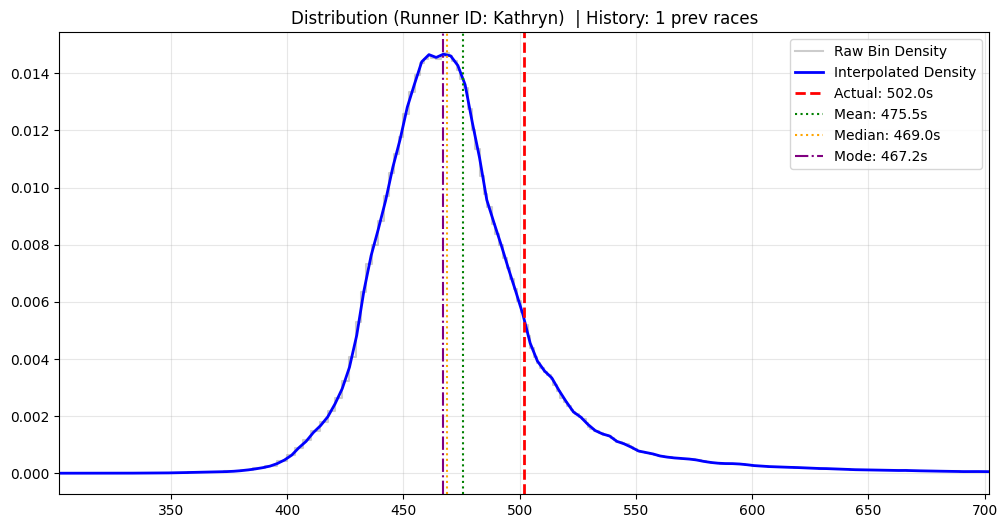

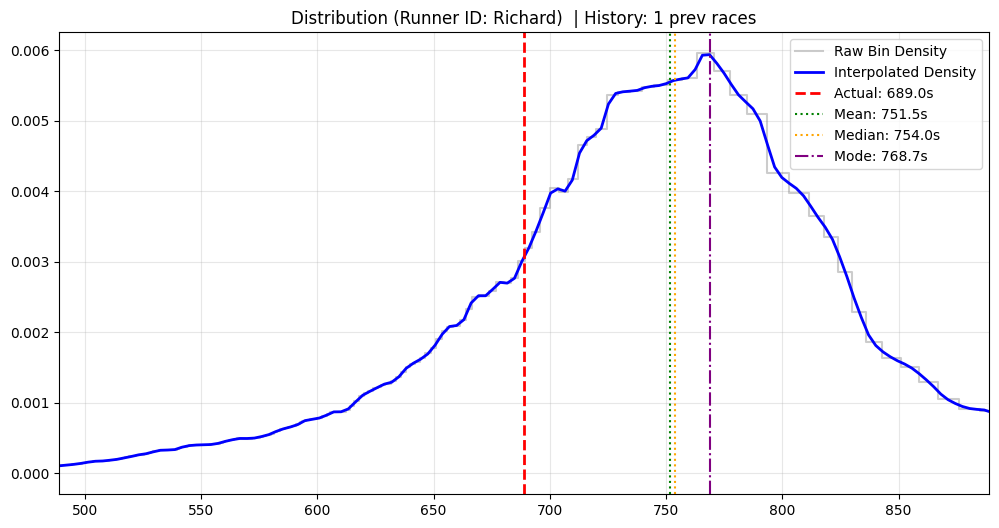

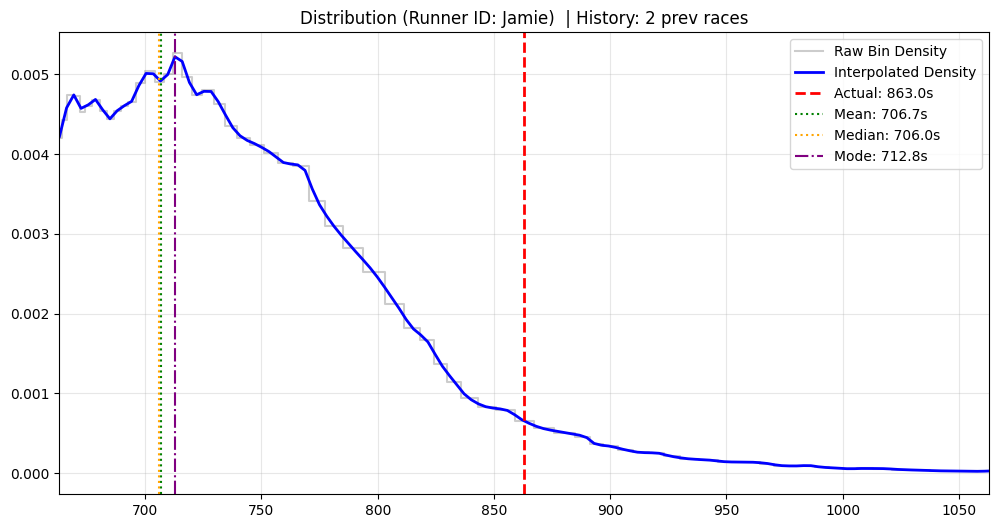

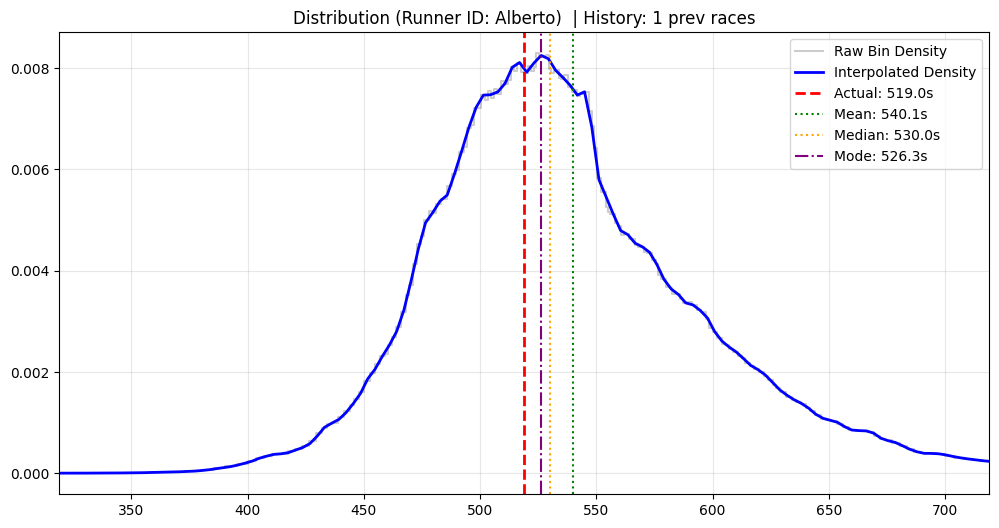

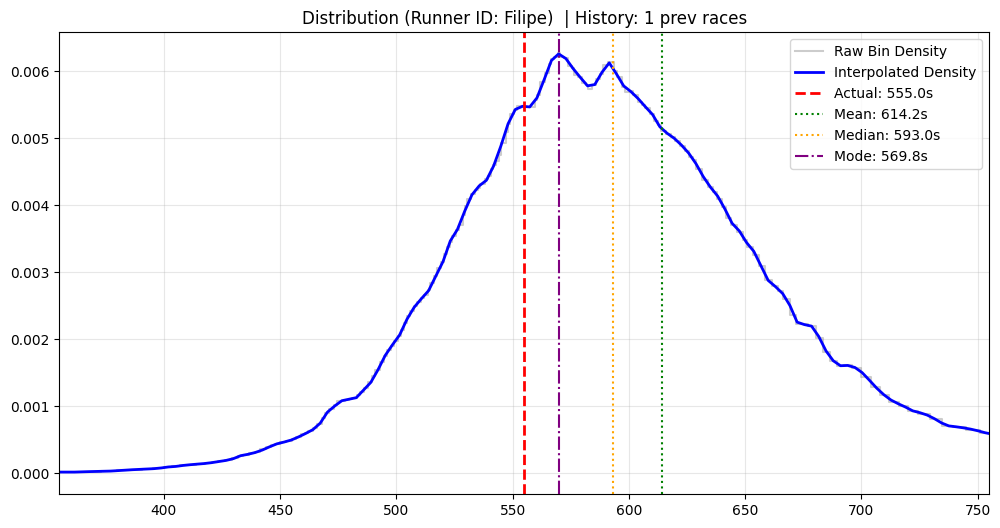

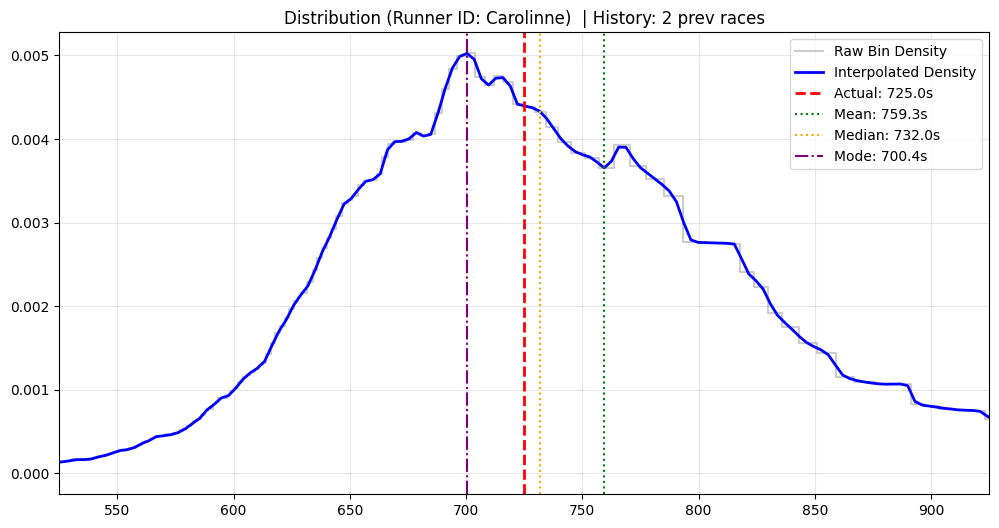

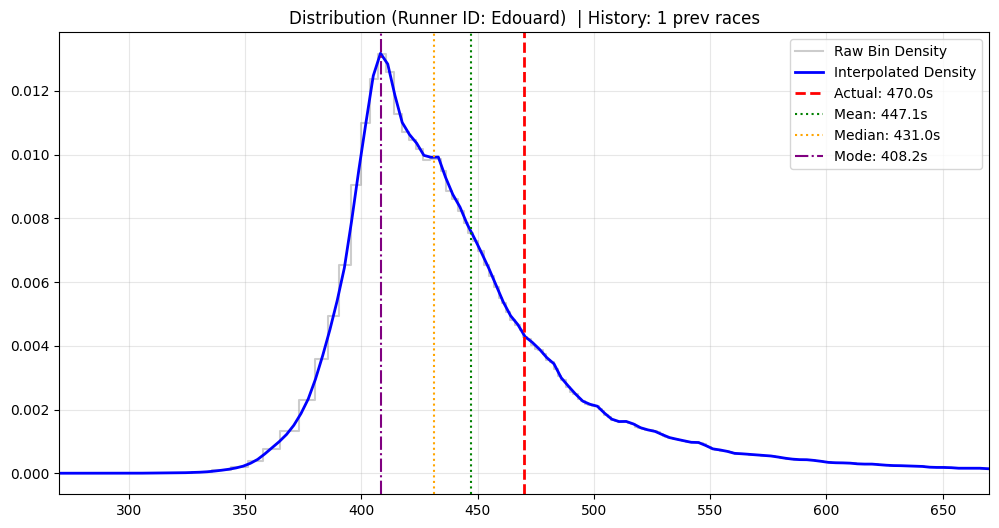

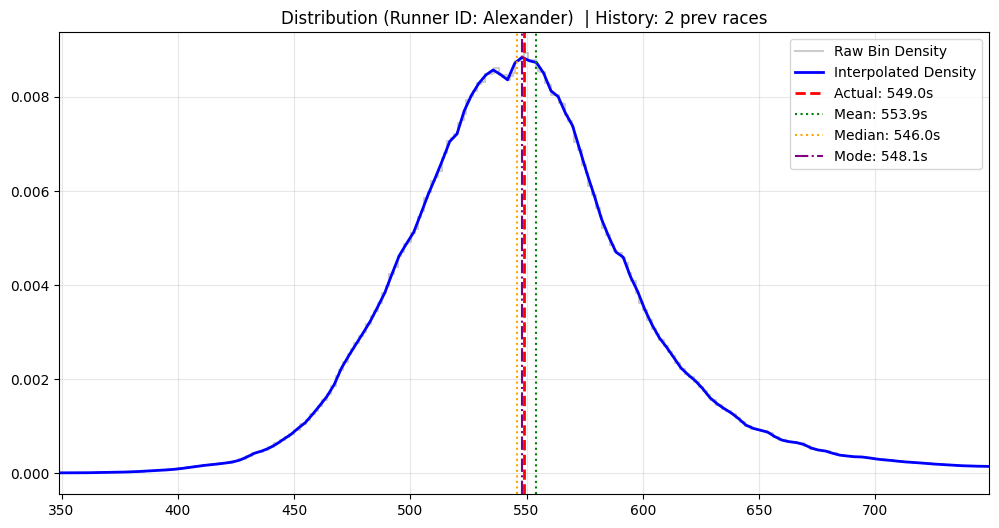

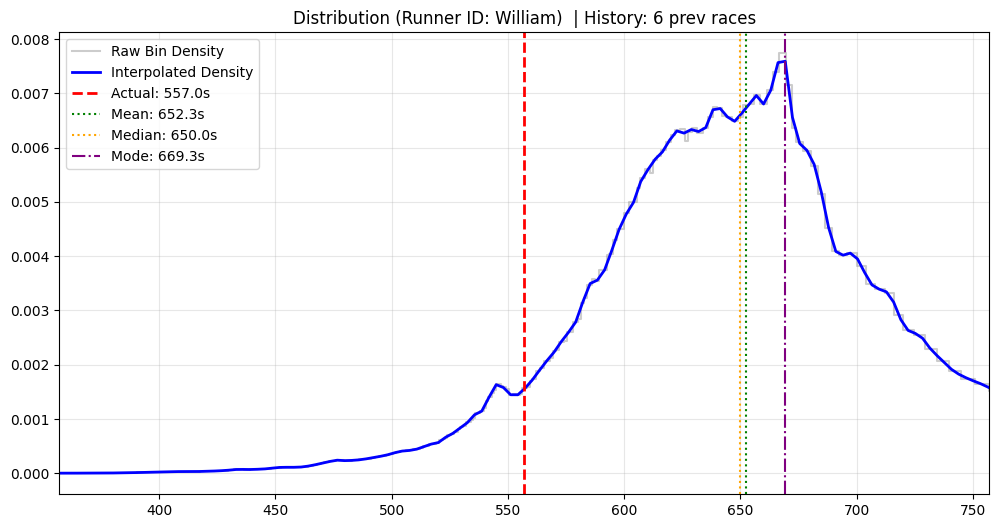

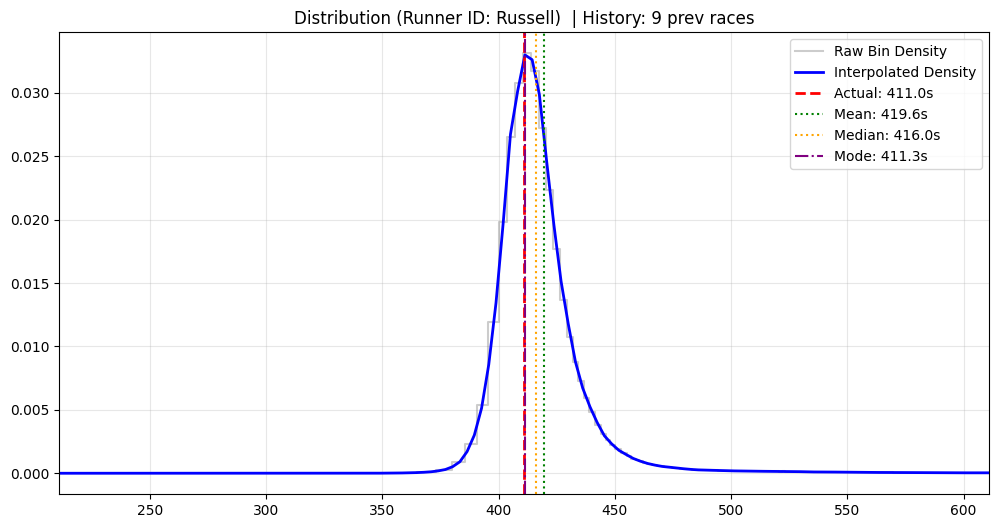

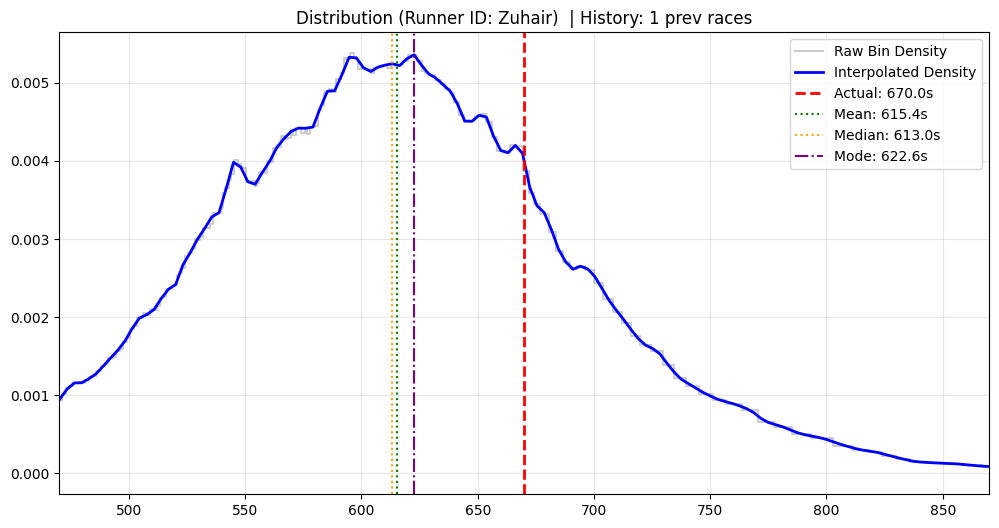

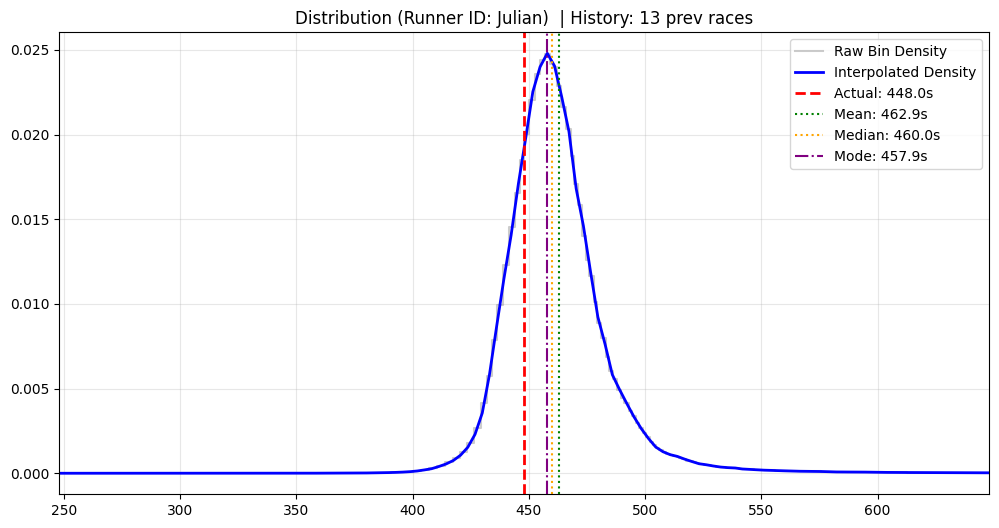

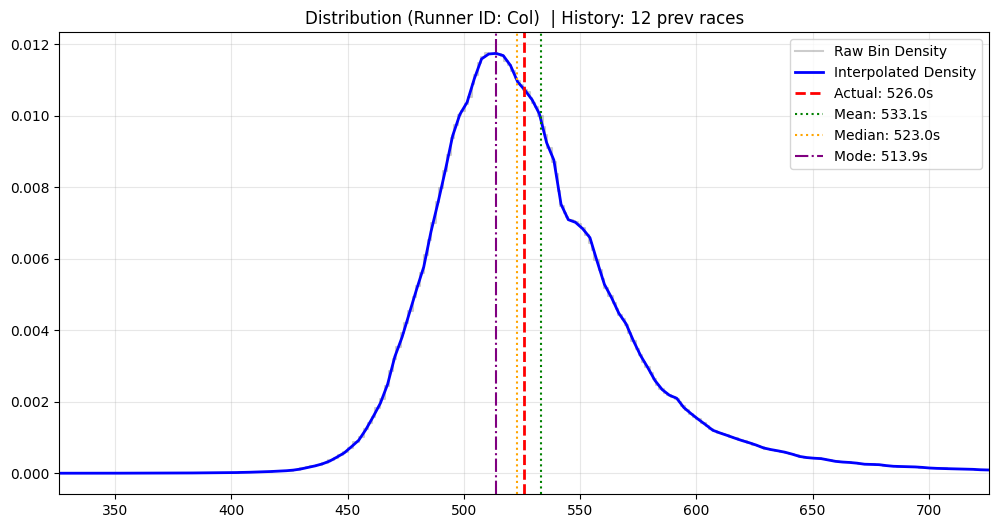

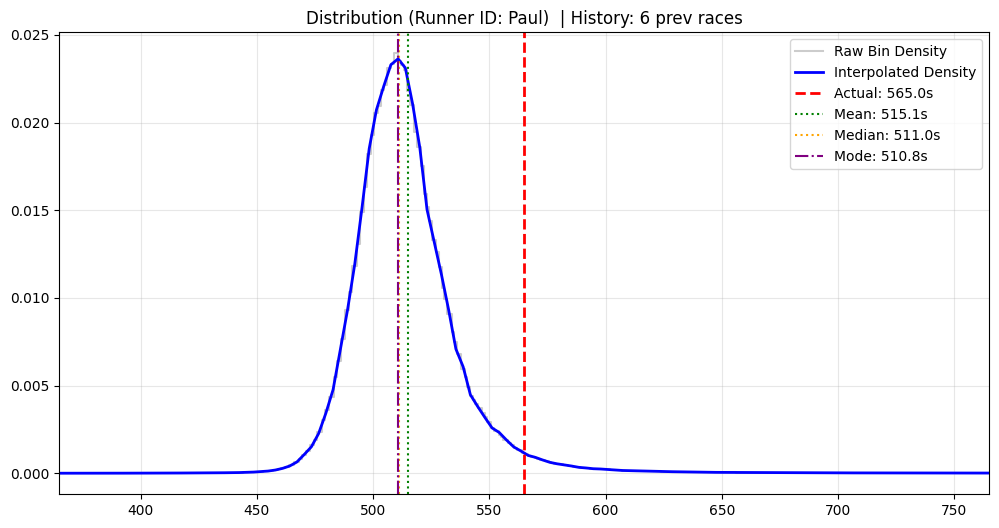

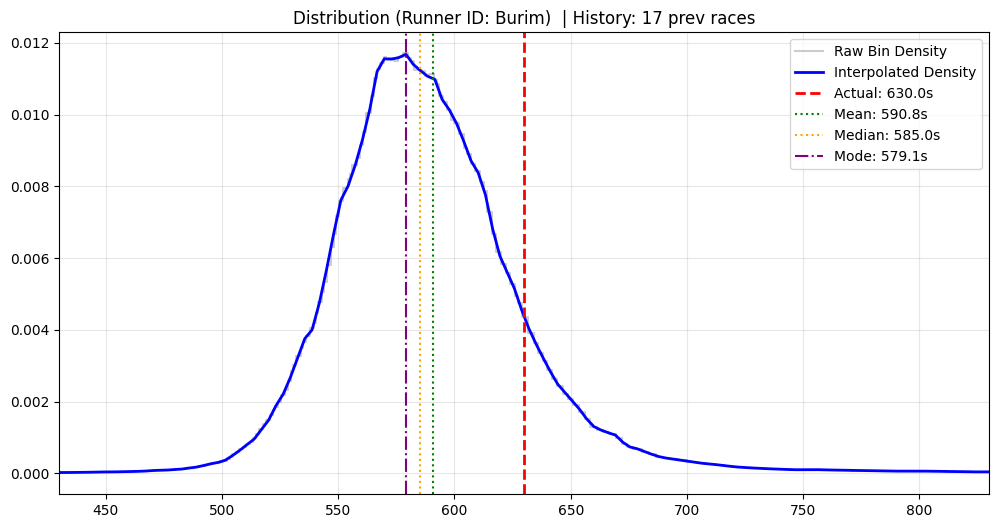

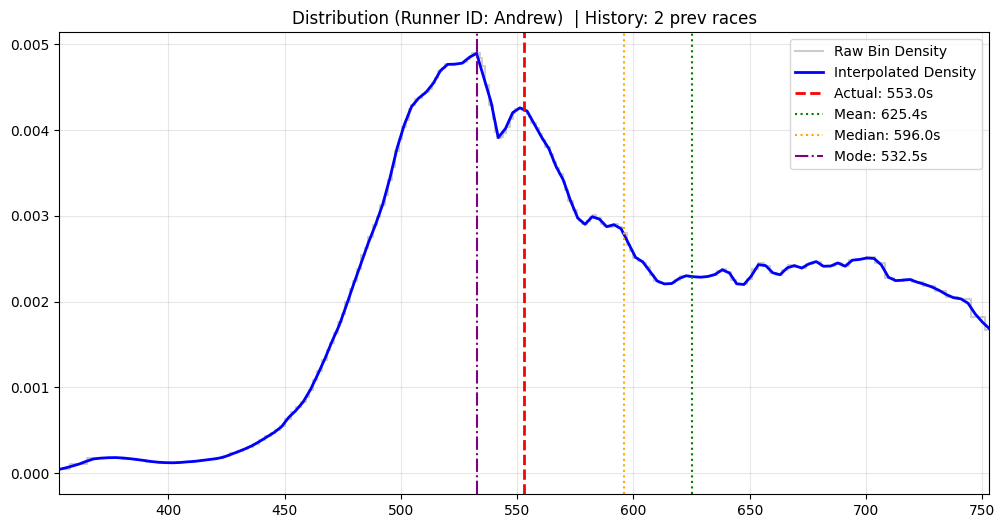

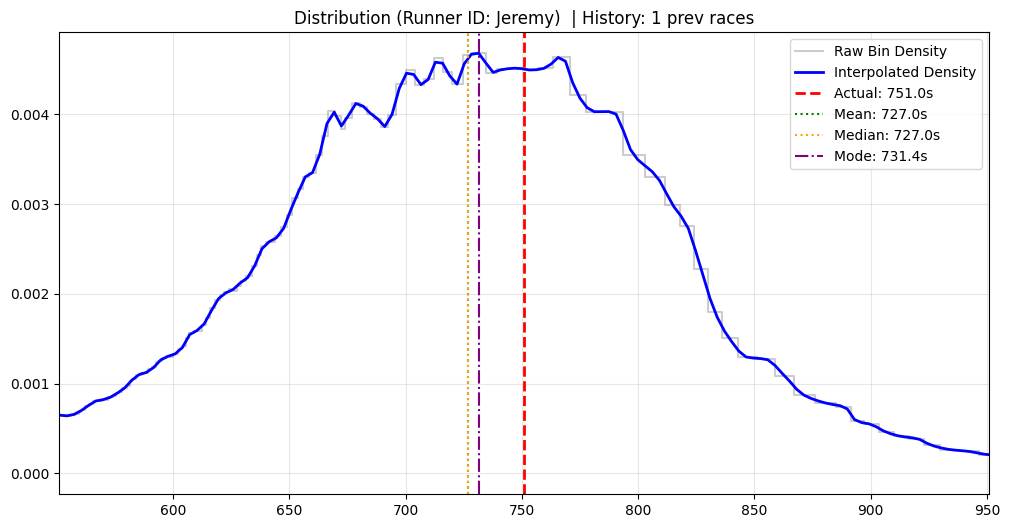

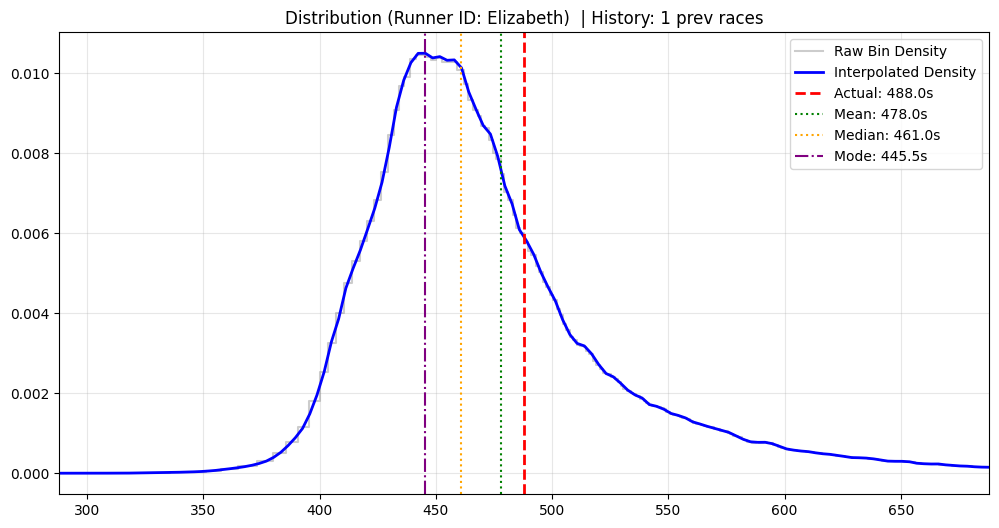

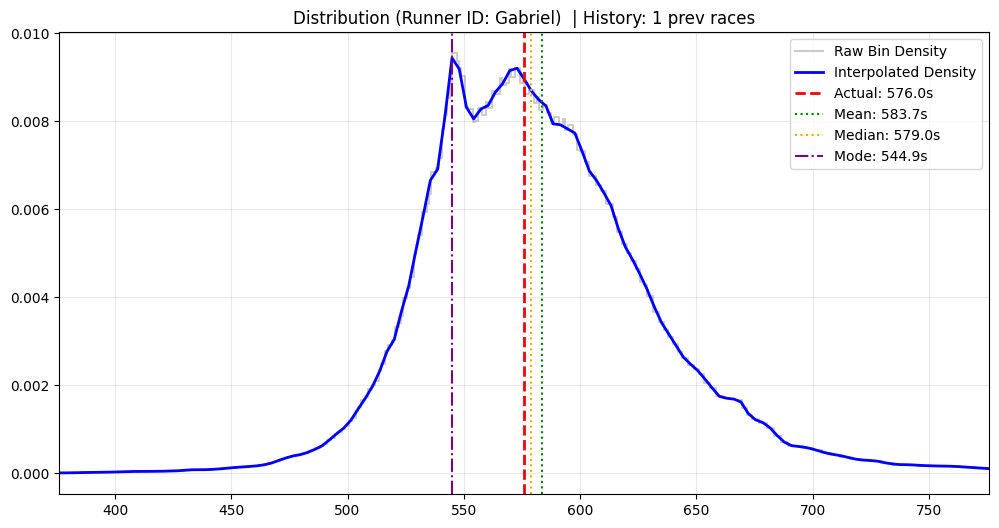

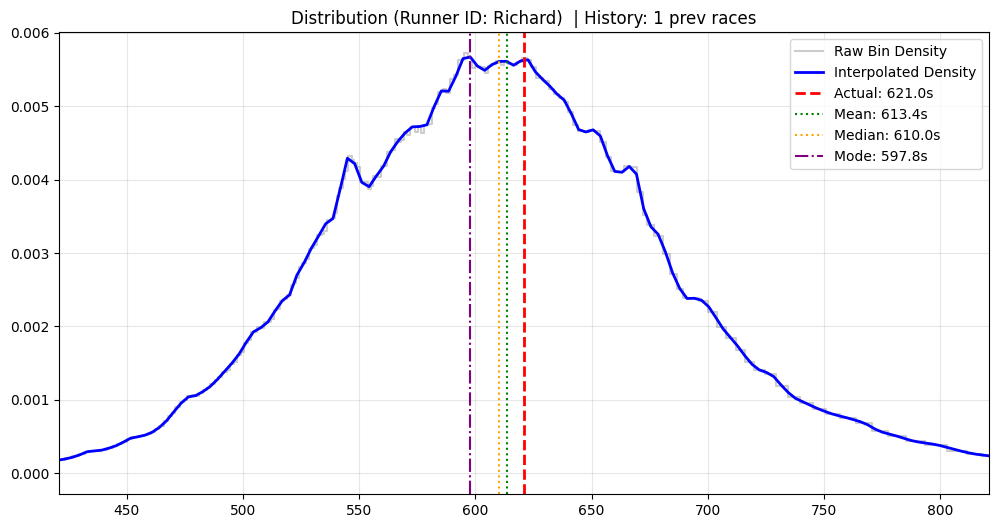

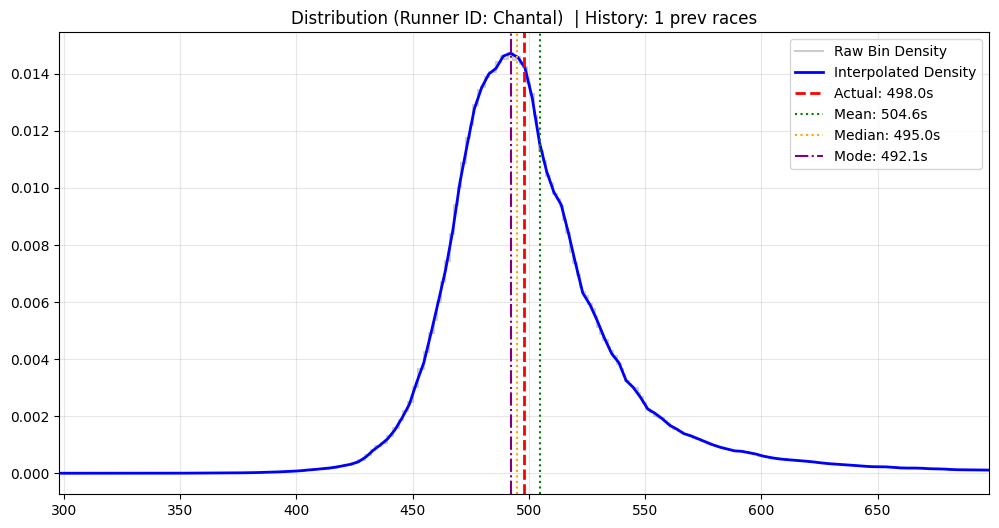

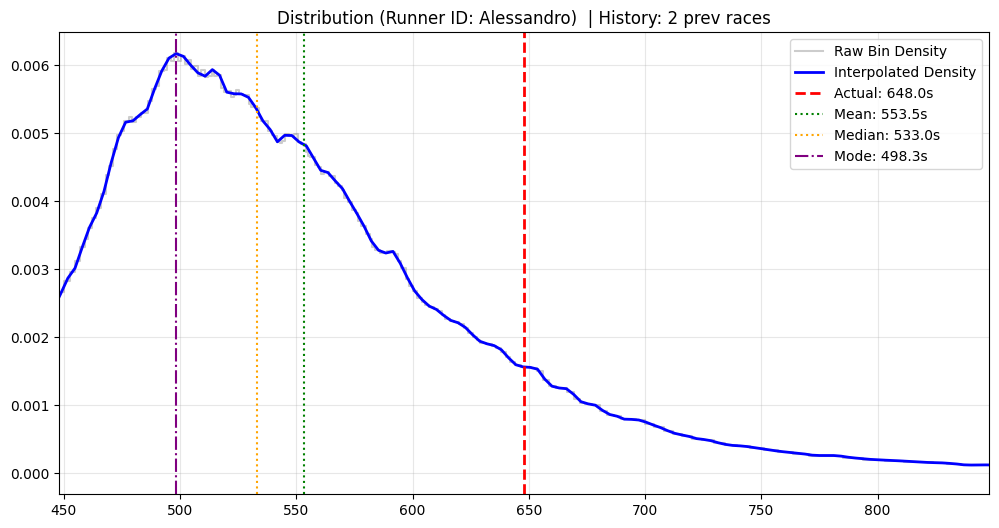

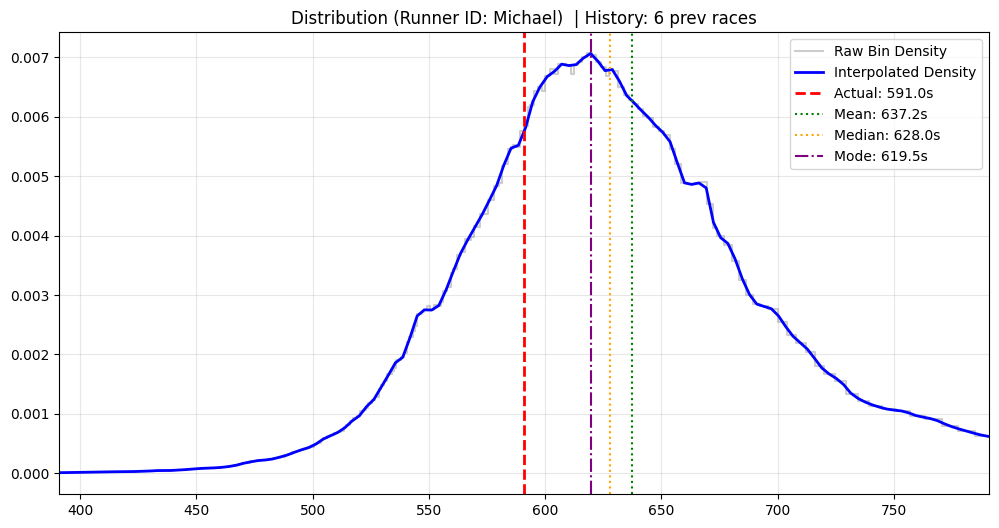

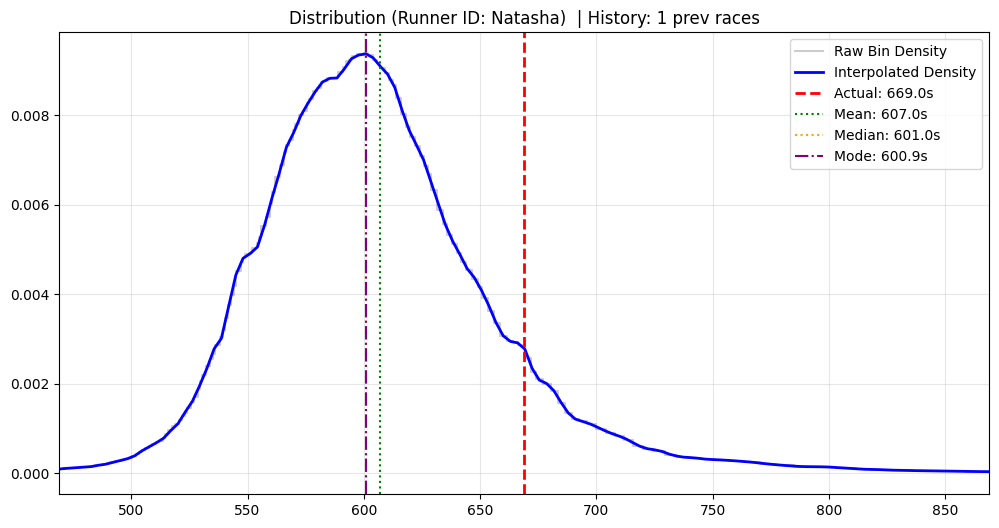

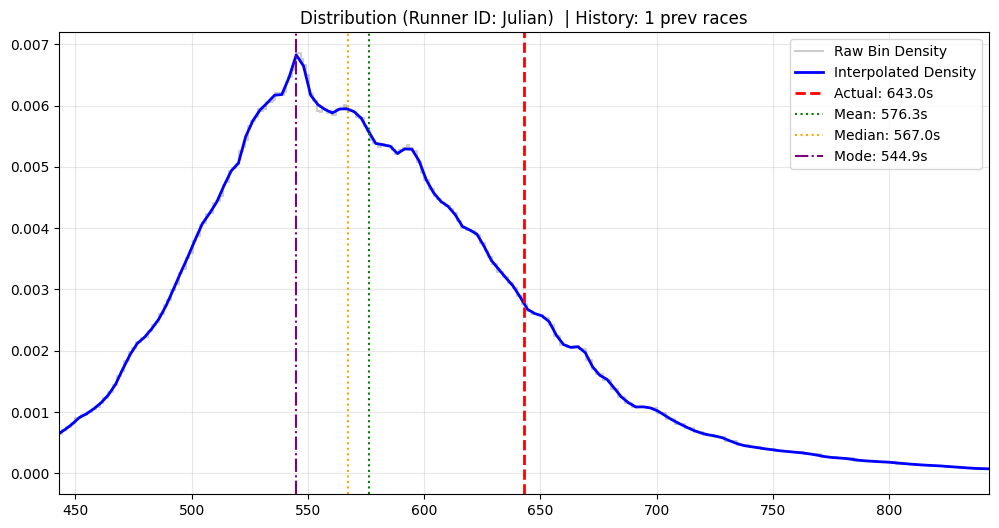

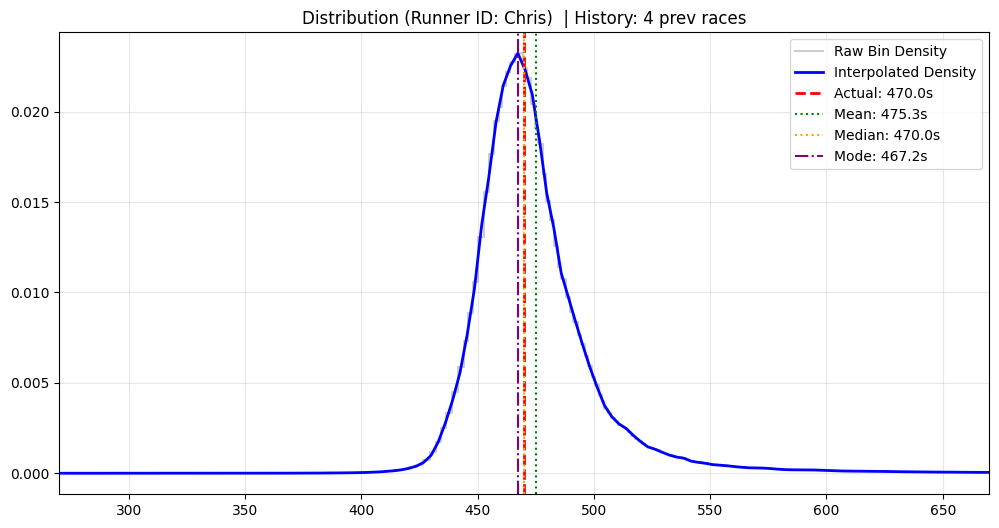

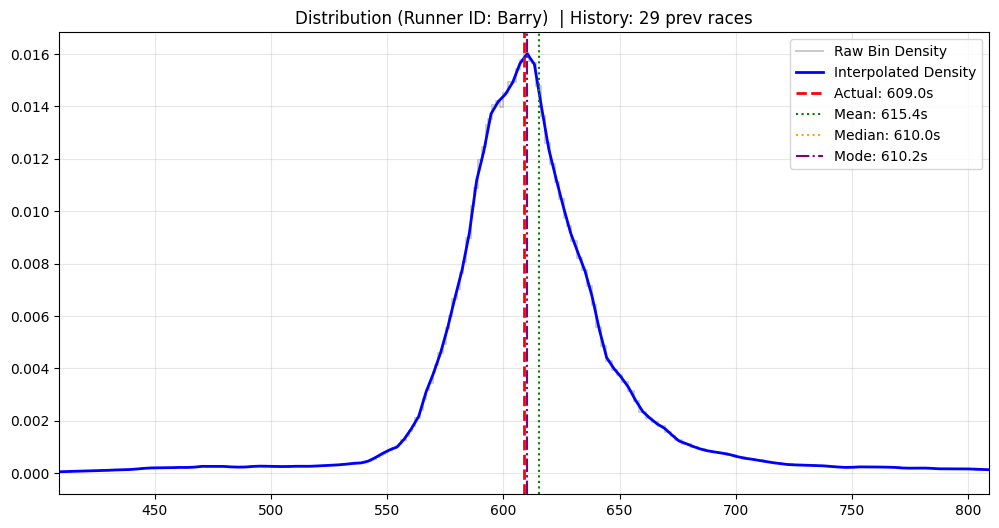

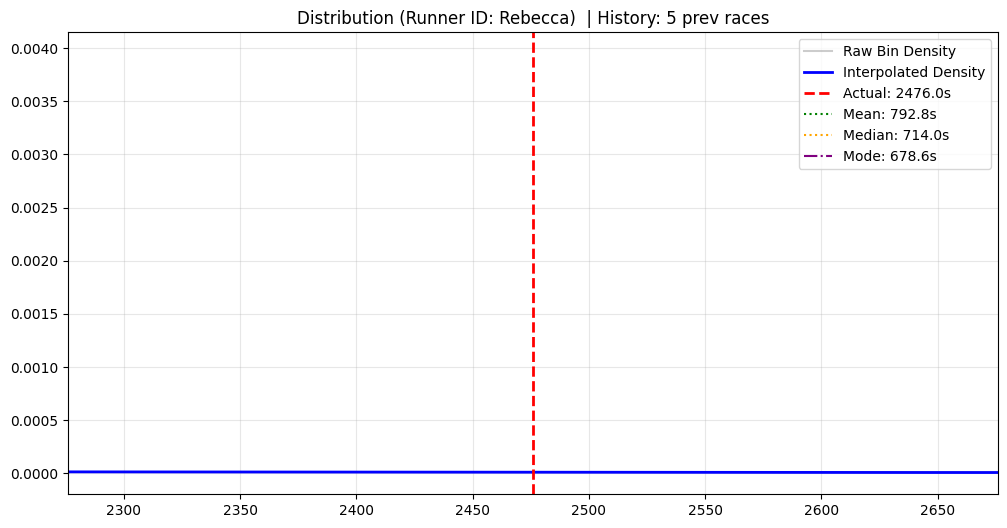

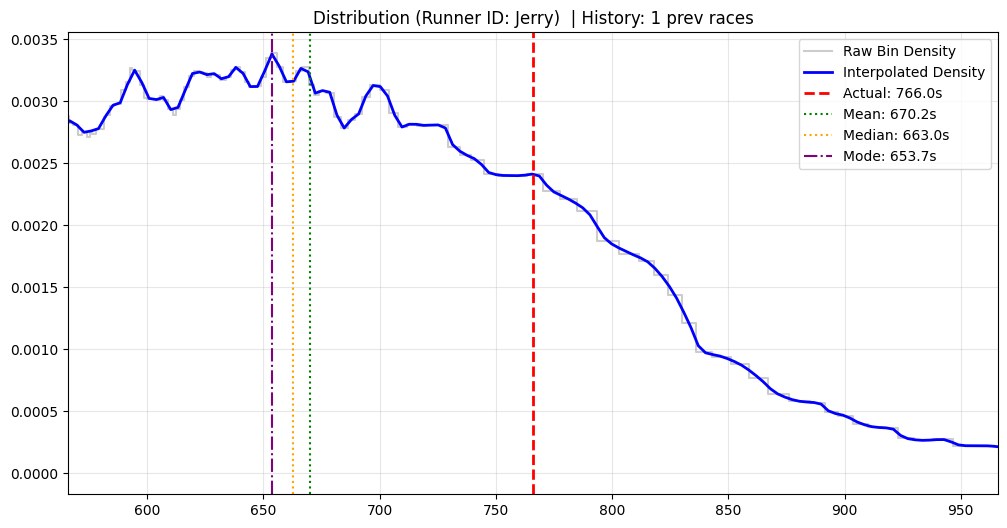

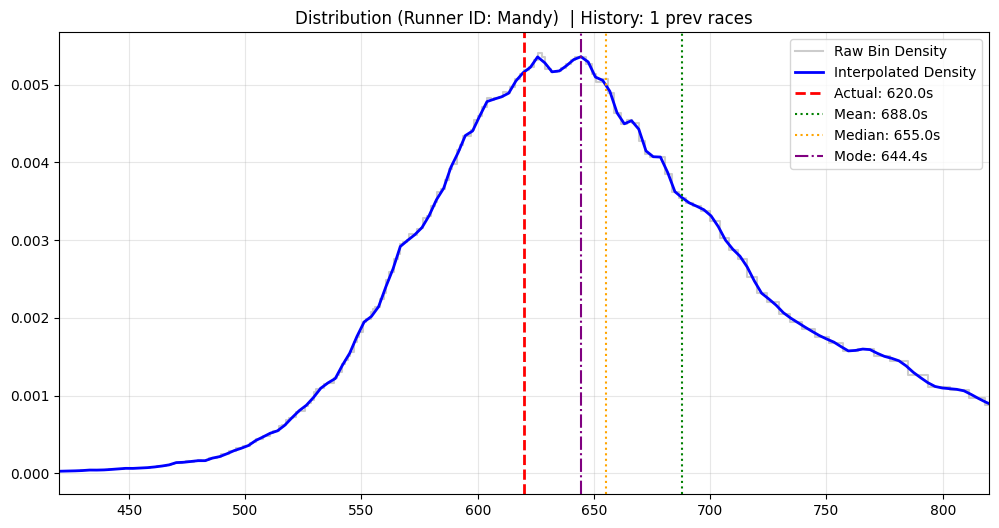

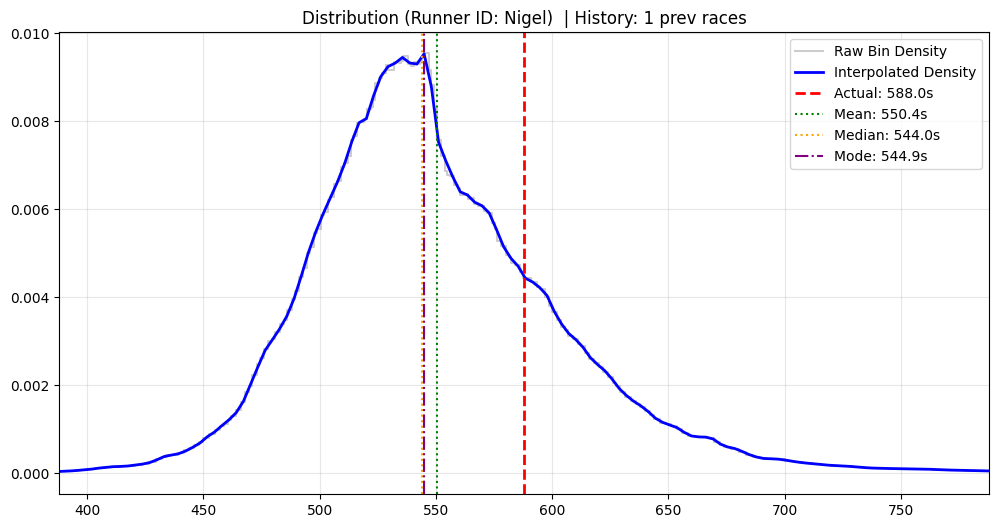

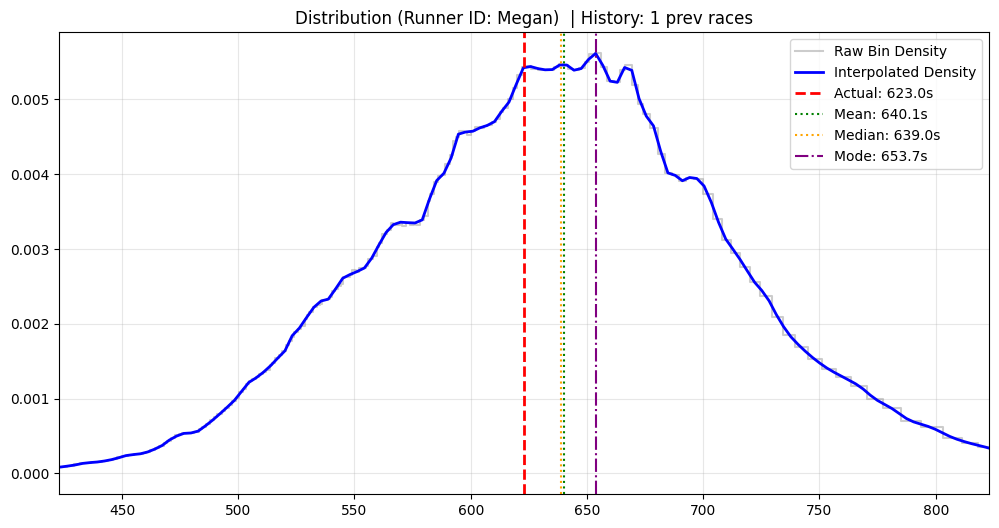

In [10]:
# --- 4. LOAD DATA & SAMPLE PLOT ---
import glob
all_files = sorted(glob.glob(DATA_SPLIT_PATH))
if not all_files:
    print(f"❌ ERROR: No files found matching {DATA_SPLIT_PATH}")
else:
    print(f"Found {len(all_files)} files matching pattern.")

inspection_runners = []
for file_path in all_files:
    print(f"Loading {file_path}...")
    with gzip.open(file_path, 'rb') as f:
        while True:
            try:
                batch = pickle.load(f)
                if isinstance(batch, list): inspection_runners.extend(batch)
                else: inspection_runners.append(batch)
            except EOFError: break

print(f"\nTotal loaded: {len(inspection_runners)} runners.")

for runner in random.sample(inspection_runners, min(50, len(inspection_runners))):
    if runner.training_examples:
        plot_prediction_distribution(random.choice(runner.training_examples), f"(Runner ID: {runner.name_gender_dedup_int[0]}) ")


In [ ]:
# --- 5. SMALL EVALUATION & HISTORY ANALYSIS ---
print('Starting comprehensive evaluation (History + Global Stats)...')
from collections import defaultdict

# Tracking for Global Stats
err_mean, err_median, err_mode, err_naive, err_last, err_riegel, err_xgb = [], [], [], [], [], [], []

# Tracking for History Analysis
results_by_history = defaultdict(lambda: {'transformer': [], 'xgb': [], 'naive': [], 'riegel': [], 'last': []})

MAX_EVAL_EXAMPLES = 10000
total_runners = 0
total_examples = 0

model.eval()
stop_early = False

for runner in inspection_runners:
    if not runner.training_examples:
        continue

    if stop_early:
        break

    total_runners += 1

    for ex in runner.training_examples:
        actual = float(ex.actual_pace_seconds)
        if np.isnan(actual):
            continue

        # --- A. PREPARE TRANSFORMER INPUT ---
        X_tokens = prepare_inference_sequence(ex, MAX_LEN, IS_SWAPPED)
        num_prev_used = len(X_tokens) // 11
        if num_prev_used < 1:
            continue

        input_ids = [VOCAB.get(t, VOCAB['<unk>']) for t in X_tokens]
        input_tensor = torch.tensor([input_ids + [0]*(MAX_LEN-len(input_ids))], dtype=torch.long).to(DEVICE)

        with torch.no_grad():
            logits = model(input_tensor, padding_mask=(input_tensor==0))
            probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

        p_probs = np.maximum(0, probs)
        p_density = p_probs / pace_widths
        p_mass = p_probs / p_probs.sum() if p_probs.sum() > 0 else p_probs

        # Mode via PCHIP (Interpolated peak)
        pace_fine = np.linspace(pace_values.min(), pace_values.max(), 1000)
        dens_fine = pchip_interpolate(pace_values, p_density, pace_fine)
        dens_fine = np.maximum(0, dens_fine)
        mode_pace = pace_fine[np.argmax(dens_fine)]

        # Mean/Median via raw mass
        pred_mean = np.sum(p_mass * pace_values)
        pred_median = pace_values[min(np.searchsorted(np.cumsum(p_mass), 0.5), len(pace_values)-1)]

        err_mean.append(abs(pred_mean - actual))
        err_median.append(abs(pred_median - actual))
        err_mode.append(abs(mode_pace - actual))
        results_by_history[num_prev_used]['transformer'].append(abs(pred_median - actual))

        # --- B. BASELINES & XGBOOST ---
        feats = extract_runner_features_full(runner, ex)
        if feats:
            e_naive = abs(feats['avg_historical_pace'] - actual)
            e_last = abs(feats['last_pace'] - actual)
            err_naive.append(e_naive)
            err_last.append(e_last)
            results_by_history[num_prev_used]['naive'].append(e_naive)
            results_by_history[num_prev_used]['last'].append(e_last)

            if xgb_booster and xgb_feature_columns:
                p_xgb = xgb_predict_from_feats(feats)
                if p_xgb is not None:
                    err_xgb.append(abs(p_xgb - actual))
                    results_by_history[num_prev_used]['xgb'].append(abs(p_xgb - actual))

        # --- C. RIEGEL ---
        if len(ex.raw_pace_data) >= 2:
            p1_d = ex.raw_pace_data[-2]; p2_d = ex.raw_pace_data[-1]
            d1 = DISTANCE_MAP.get(p1_d[0]); d2 = DISTANCE_MAP.get(p2_d[0])
            if d1 and d2:
                p_ri = float(p1_d[2]) * (d2/d1)**0.06
                err_riegel.append(abs(p_ri - actual))
                results_by_history[num_prev_used]['riegel'].append(abs(p_ri - actual))

        total_examples += 1
        if total_examples % 200 == 0:
            print(f'Processed {total_examples} examples...')

        if total_examples >= MAX_EVAL_EXAMPLES:
            stop_early = True
            break

print(f'\nDONE! Evaluated {total_examples} races across {total_runners} runners.')

print(f"\nSUMMARY STATS (n={total_examples} race predictions)")
print("-"*45)
print(f"Naive Mean MAE:       {np.mean(err_naive):.2f}s")
print(f"Last Race Pace MAE:   {np.mean(err_last):.2f}s")
print(f"Riegel Formula MAE:   {np.mean(err_riegel):.2f}s")
print(f"Transformer (Mean):   {np.mean(err_mean):.2f}s")
print(f"Transformer (Median): {np.mean(err_median):.2f}s")
print(f"Transformer (Mode):   {np.mean(err_mode):.2f}s")
if err_xgb: print(f"XGBoost MAE:           {np.mean(err_xgb):.2f}s")

history_lengths = sorted([h for h in results_by_history.keys() if 1 <= h <= 25])
plt.figure(figsize=(14, 7))
metrics = ['transformer', 'xgb', 'riegel']
colors = ['#1f77b4', '#2ca02c', '#d62728']
markers = ['o', 's', '^']
for m, c, mk in zip(metrics, colors, markers):
    valid_h = [h for h in history_lengths if len(results_by_history[h][m]) >= 5]
    maes = [np.mean(results_by_history[h][m]) for h in valid_h]
    # Calculate Standard Error (SEM)
    sems = [np.std(results_by_history[h][m]) / np.sqrt(len(results_by_history[h][m])) for h in valid_h]
    
    plt.errorbar(valid_h, maes, yerr=sems, marker=mk, label=m.capitalize(), 
                 color=c, linewidth=2, markersize=8, capsize=4, elinewidth=1, alpha=0.8)
    if m == 'transformer':
        for h, val in zip(valid_h, maes):
            plt.annotate(f'n={len(results_by_history[h][m])}', (h, val), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
plt.title('MAE vs Experience: Accuracy by Number of Previous Races Seen by Model')
plt.xlabel('Number of Previous Races in Context Window')
plt.ylabel('Mean Absolute Error (seconds)')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.xticks(history_lengths); plt.tight_layout(); plt.show()

# --- DISPLAY PERCENTAGE IMPROVEMENT PLOT ---
plt.figure(figsize=(12, 6))
h_range = sorted([h for h in results_by_history.keys() if 1 <= h <= 15])
improvements = []
valid_h = []

for h in h_range:
    t_mae = np.mean(results_by_history[h]['transformer'])
    x_mae = np.mean(results_by_history[h]['xgb'])
    if not np.isnan(t_mae) and not np.isnan(x_mae) and x_mae > 0:
        pct = (x_mae - t_mae) / x_mae * 100
        improvements.append(pct)
        valid_h.append(h)

plt.plot(valid_h, improvements, marker='P', color='#2ca02c', linewidth=3, markersize=10, label='% Improvement vs XGBoost')
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.title('Transformer Gain over XGBoost by Experience Level')
plt.xlabel('Number of Previous Races in Context Window')
plt.ylabel('Percentage Improvement (%)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(h_range)
for i, val in enumerate(improvements):
    plt.annotate(f'{val:.1f}%', (valid_h[i], improvements[i]), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')
plt.ylim(0, max(improvements)*1.3 if improvements else 20)
plt.legend(); plt.tight_layout(); plt.show()


Starting comprehensive evaluation (History + Global Stats)...
Processed 200 examples...
Processed 400 examples...
Processed 600 examples...
Processed 800 examples...
Processed 1000 examples...
Processed 1200 examples...
Processed 1400 examples...
Processed 1600 examples...
Processed 1800 examples...
Processed 2000 examples...
Processed 2200 examples...
Processed 2400 examples...
Processed 2600 examples...
Processed 2800 examples...
Processed 3000 examples...
Processed 3200 examples...
Processed 3400 examples...
Processed 3600 examples...
Processed 3800 examples...
Processed 4000 examples...
Processed 4200 examples...
Processed 4400 examples...
Processed 4600 examples...
Processed 4800 examples...
Processed 5000 examples...
Processed 5200 examples...
Processed 5400 examples...
Processed 5600 examples...
Processed 5800 examples...
Processed 6000 examples...


Starting comprehensive evaluation (History + Global Stats)...
Processed 2000 examples...
Processed 4000 examples...
Processed 6000 examples...
Processed 8000 examples...
Processed 10000 examples...
Processed 12000 examples...
Processed 14000 examples...
Processed 16000 examples...
Processed 18000 examples...
Processed 20000 examples...
Processed 22000 examples...
Processed 24000 examples...
Processed 26000 examples...
Processed 28000 examples...
Processed 30000 examples...
Processed 32000 examples...
Processed 34000 examples...
Processed 36000 examples...
Processed 38000 examples...
Processed 40000 examples...
Processed 42000 examples...
Processed 44000 examples...
Processed 46000 examples...
Processed 48000 examples...
Processed 50000 examples...
Processed 52000 examples...
Processed 54000 examples...
Processed 56000 examples...
Processed 58000 examples...
Processed 60000 examples...
Processed 62000 examples...
Processed 64000 examples...
Processed 66000 examples...
Processed 68000 ex

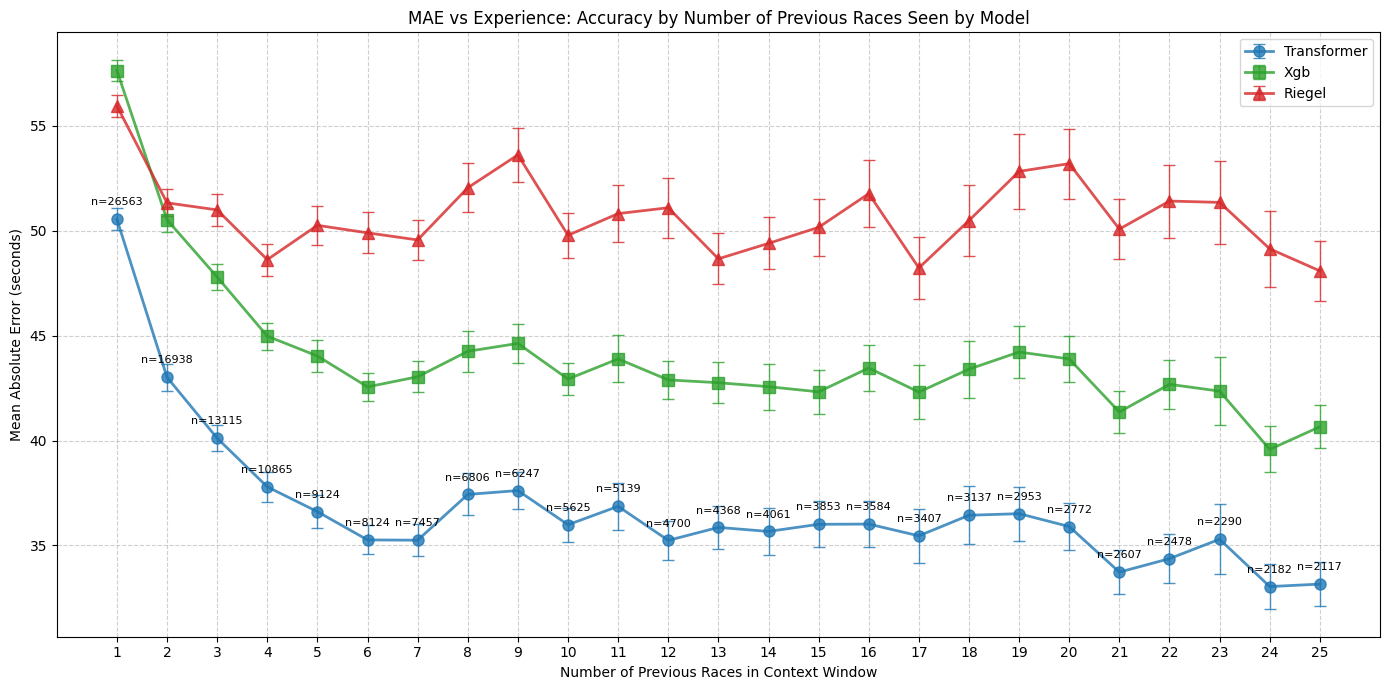

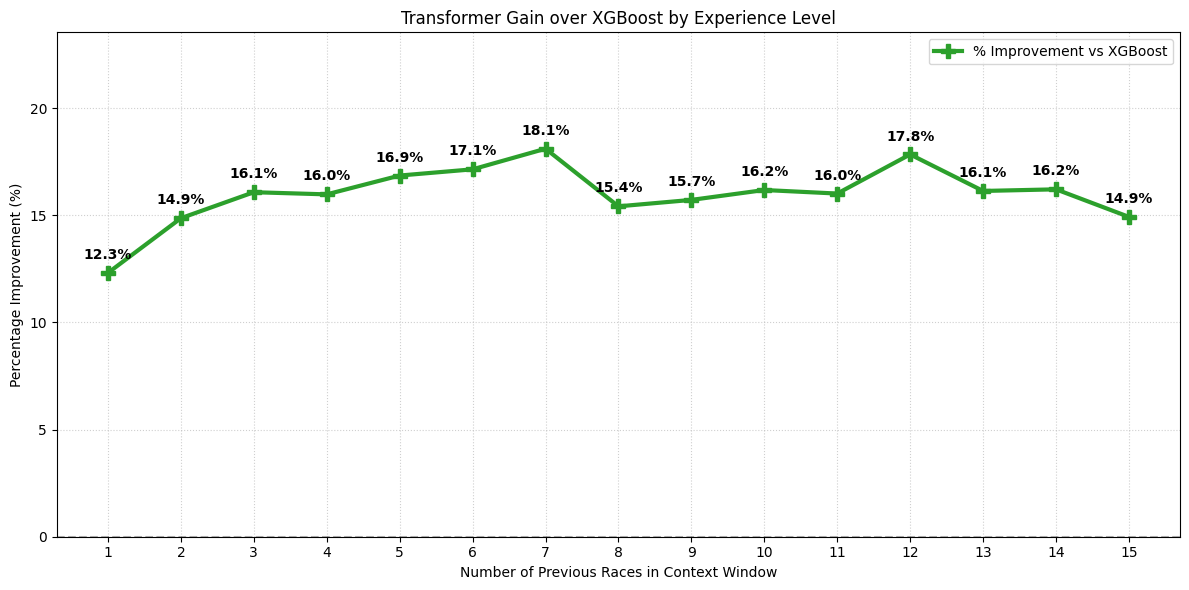

In [ ]:
# --- 6. SMALL EVALUATION & HISTORY ANALYSIS ---
print('Starting comprehensive evaluation (History + Global Stats)...')
from collections import defaultdict

# Tracking for Global Stats
err_mean, err_median, err_mode, err_naive, err_last, err_riegel, err_xgb = [], [], [], [], [], [], []

# Tracking for History Analysis
results_by_history = defaultdict(lambda: {'transformer': [], 'xgb': [], 'naive': [], 'riegel': [], 'last': []})

MAX_EVAL_EXAMPLES = 200000
total_runners = 0
total_examples = 0

model.eval()
stop_early = False

for runner in inspection_runners:
    if not runner.training_examples:
        continue

    if stop_early:
        break

    total_runners += 1

    for ex in runner.training_examples:
        actual = float(ex.actual_pace_seconds)
        if np.isnan(actual):
            continue

        # --- A. PREPARE TRANSFORMER INPUT ---
        X_tokens = prepare_inference_sequence(ex, MAX_LEN, IS_SWAPPED)
        num_prev_used = len(X_tokens) // 11
        if num_prev_used < 1:
            continue

        input_ids = [VOCAB.get(t, VOCAB['<unk>']) for t in X_tokens]
        input_tensor = torch.tensor([input_ids + [0]*(MAX_LEN-len(input_ids))], dtype=torch.long).to(DEVICE)

        with torch.no_grad():
            logits = model(input_tensor, padding_mask=(input_tensor==0))
            probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

        p_probs = np.maximum(0, probs)
        p_density = p_probs / pace_widths
        p_mass = p_probs / p_probs.sum() if p_probs.sum() > 0 else p_probs

        # Mode via PCHIP (Interpolated peak)
        pace_fine = np.linspace(pace_values.min(), pace_values.max(), 1000)
        dens_fine = pchip_interpolate(pace_values, p_density, pace_fine)
        dens_fine = np.maximum(0, dens_fine)
        mode_pace = pace_fine[np.argmax(dens_fine)]

        # Mean/Median via raw mass
        pred_mean = np.sum(p_mass * pace_values)
        pred_median = pace_values[min(np.searchsorted(np.cumsum(p_mass), 0.5), len(pace_values)-1)]

        err_mean.append(abs(pred_mean - actual))
        err_median.append(abs(pred_median - actual))
        err_mode.append(abs(mode_pace - actual))
        results_by_history[num_prev_used]['transformer'].append(abs(pred_median - actual))

        # --- B. BASELINES & XGBOOST ---
        feats = extract_runner_features_full(runner, ex)
        if feats:
            e_naive = abs(feats['avg_historical_pace'] - actual)
            e_last = abs(feats['last_pace'] - actual)
            err_naive.append(e_naive)
            err_last.append(e_last)
            results_by_history[num_prev_used]['naive'].append(e_naive)
            results_by_history[num_prev_used]['last'].append(e_last)

            if xgb_booster and xgb_feature_columns:
                p_xgb = xgb_predict_from_feats(feats)
                if p_xgb is not None:
                    err_xgb.append(abs(p_xgb - actual))
                    results_by_history[num_prev_used]['xgb'].append(abs(p_xgb - actual))

        # --- C. RIEGEL ---
        if len(ex.raw_pace_data) >= 2:
            p1_d = ex.raw_pace_data[-2]; p2_d = ex.raw_pace_data[-1]
            d1 = DISTANCE_MAP.get(p1_d[0]); d2 = DISTANCE_MAP.get(p2_d[0])
            if d1 and d2:
                p_ri = float(p1_d[2]) * (d2/d1)**0.06
                err_riegel.append(abs(p_ri - actual))
                results_by_history[num_prev_used]['riegel'].append(abs(p_ri - actual))

        total_examples += 1
        if total_examples % 2000 == 0:
            print(f'Processed {total_examples} examples...')

        if total_examples >= MAX_EVAL_EXAMPLES:
            stop_early = True
            break

print(f'\nDONE! Evaluated {total_examples} races across {total_runners} runners.')

print(f"\nSUMMARY STATS (n={total_examples} race predictions)")
print("-"*45)
print(f"Naive Mean MAE:       {np.mean(err_naive):.2f}s")
print(f"Last Race Pace MAE:   {np.mean(err_last):.2f}s")
print(f"Riegel Formula MAE:   {np.mean(err_riegel):.2f}s")
print(f"Transformer (Mean):   {np.mean(err_mean):.2f}s")
print(f"Transformer (Median): {np.mean(err_median):.2f}s")
print(f"Transformer (Mode):   {np.mean(err_mode):.2f}s")
if err_xgb: print(f"XGBoost MAE:           {np.mean(err_xgb):.2f}s")

history_lengths = sorted([h for h in results_by_history.keys() if 1 <= h <= 25])
plt.figure(figsize=(14, 7))
metrics = ['transformer', 'xgb', 'riegel']
colors = ['#1f77b4', '#2ca02c', '#d62728']
markers = ['o', 's', '^']
for m, c, mk in zip(metrics, colors, markers):
    valid_h = [h for h in history_lengths if len(results_by_history[h][m]) >= 5]
    maes = [np.mean(results_by_history[h][m]) for h in valid_h]
    # Calculate Standard Error (SEM)
    sems = [np.std(results_by_history[h][m]) / np.sqrt(len(results_by_history[h][m])) for h in valid_h]
    
    plt.errorbar(valid_h, maes, yerr=sems, marker=mk, label=m.capitalize(), 
                 color=c, linewidth=2, markersize=8, capsize=4, elinewidth=1, alpha=0.8)
    if m == 'transformer':
        for h, val in zip(valid_h, maes):
            plt.annotate(f'n={len(results_by_history[h][m])}', (h, val), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
plt.title('MAE vs Experience: Accuracy by Number of Previous Races Seen by Model')
plt.xlabel('Number of Previous Races in Context Window')
plt.ylabel('Mean Absolute Error (seconds)')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.xticks(history_lengths); plt.tight_layout(); plt.show()

# --- DISPLAY PERCENTAGE IMPROVEMENT PLOT ---
plt.figure(figsize=(12, 6))
h_range = sorted([h for h in results_by_history.keys() if 1 <= h <= 15])
improvements = []
valid_h = []

for h in h_range:
    t_mae = np.mean(results_by_history[h]['transformer'])
    x_mae = np.mean(results_by_history[h]['xgb'])
    if not np.isnan(t_mae) and not np.isnan(x_mae) and x_mae > 0:
        pct = (x_mae - t_mae) / x_mae * 100
        improvements.append(pct)
        valid_h.append(h)

plt.plot(valid_h, improvements, marker='P', color='#2ca02c', linewidth=3, markersize=10, label='% Improvement vs XGBoost')
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.title('Transformer Gain over XGBoost by Experience Level')
plt.xlabel('Number of Previous Races in Context Window')
plt.ylabel('Percentage Improvement (%)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(h_range)
for i, val in enumerate(improvements):
    plt.annotate(f'{val:.1f}%', (valid_h[i], improvements[i]), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')
plt.ylim(0, max(improvements)*1.3 if improvements else 20)
plt.legend(); plt.tight_layout(); plt.show()